In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model as skl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

import sys
sys.path.insert(0,"../src_fork/")
sys.path.insert(0,"../src_fork/analysis")

import linear_regression
import utils
import stat_tools
import crossvalidation
import bootstrap
from FrankeFunction import FrankeFunction

from imageio import imread


utils.plot_settings()  # LaTeX fonts in Plots!

FIGPATH = "../figs/"
FIGURESIZE= np.array([4,3]) # Good default figure size for tex documents

SEEDVAL = 2020

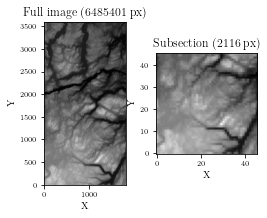

In [2]:
# Setting up the terrain data:
# Note structure! X-coordinates are on the rows of terrain_data
# Point_selection.flatten() moves most rapidly over the x-coordinates
# Meshgrids flattened also move most rapidly over the x-coordinates. Thus
# this should make z(x,y).reshape(length_y,length_x) be consistent with terrain_data

np.random.seed(SEEDVAL)
terrain_data = imread("../datafiles/SRTM_data_Norway_1.tif")
point_selection = terrain_data[:1801:40, :1801:40]  # Make quadratic and downsample
x_terrain_selection = np.linspace(0, 1, point_selection.shape[1])
y_terrain_selection = np.linspace(0, 1, point_selection.shape[0])
X_coord_selection, Y_coord_selection = np.meshgrid(x_terrain_selection, y_terrain_selection)
z_terrain_selection = point_selection.flatten()  # the response values
x_terrain_selection_flat = X_coord_selection.flatten()  # the first degree feature variables
y_terrain_selection_flat = Y_coord_selection.flatten()  # the first degree feature variables
# Would take ~ 90 hours to run on my PC with these parameters. (didnt estimate untill ~6 hours in...)
# Should be better with these parameters.
max_degree = 25
n_lambdas = 20
n_bootstraps = 100
k_folds = 5
lambdas = np.logspace(-5, 1, n_lambdas)
subset_lambdas = lambdas[::5]


x = x_terrain_selection_flat
y = y_terrain_selection_flat
z = z_terrain_selection


x_train, x_test, y_train, y_test, z_train, z_test = train_test_split(x, y, z, test_size=0.2)

# Centering
z_intercept = np.mean(z)
z = z - z_intercept

z_train_intercept = np.mean(z_train)
z_train = z_train - z_train_intercept
z_test = z_test - z_train_intercept

# Show the terrain
plt.figure(figsize=FIGURESIZE)
plt.subplot(121)
plt.title(f"Full image ({terrain_data.size} px)")
plt.imshow(terrain_data, cmap="gray", origin="lower")
plt.xlabel("X")
plt.ylabel("Y")
plt.subplot(122)
plt.imshow(point_selection, cmap="gray", origin="lower")
plt.title(f"Subsection ({point_selection.size} px)")
plt.xlabel("X")
plt.ylabel("Y")
plt.savefig(FIGPATH+"TerrainData.pdf")
plt.show()

In [3]:
# Set up the scaler

def p1_analysis(x, y, z, degrees):
    mse = pd.DataFrame(columns=["train", "test"], index = degrees)
    r2 = pd.DataFrame(columns=["train", "test"], index = degrees)
    
    max_num_betas = int((degrees[-1] + 1) * (degrees[-1] + 2) / 2)
    betas = np.zeros([len(degrees), max_num_betas])
    var_betas = np.zeros([len(degrees), max_num_betas])

    for i, deg in enumerate(degrees):
        X = linear_regression.design_matrix_2D(x, y, deg)
        # Split data, but don't shuffle. OK since data is already randomly sampled! 
        # Fasilitates a direct comparrison of the clean & Noisy data
        X_train, X_test, z_train, z_test = train_test_split(X, z, test_size = 0.2, shuffle=True)
        # Normalize data sets
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_train[:, 0] = np.ones(X_train.shape[0])
        X_test = scaler.transform(X_test)
        X_test[:, 0] = np.ones(X_test.shape[0])

        beta = linear_regression.OLS_SVD_2D(X_train, z_train)
    
        mse["train"][i] = stat_tools.MSE(z_train, X_train @ beta)
        mse["test"][i] = stat_tools.MSE(z_test, X_test @ beta)
        r2["train"][i] = stat_tools.R2(z_train, X_train @ beta)
        r2["test"][i] = stat_tools.R2(z_test, X_test @ beta)
        
        #betas[i, 0:len(beta)] = beta
        #var_betas[i, 0:len(beta)] = stat_tools.var_beta(X_train)

    return mse, r2, betas, var_betas

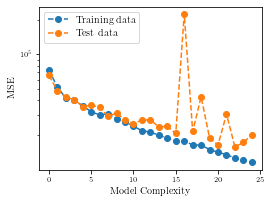

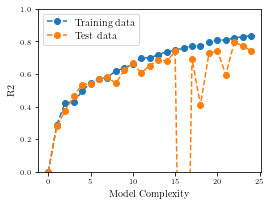

In [4]:
degrees = np.arange(0, max_degree) # Degrees of the polynomial

# Generate data
MSE_clean, R2_clean, betas, var_betas = p1_analysis(x, y, z, degrees)

plt.figure(figsize=FIGURESIZE)
plt.tight_layout()
# Plot MSE
plt.plot(degrees, MSE_clean["train"],"o--", label = "Training data")
plt.plot(degrees, MSE_clean["test"],"o--", label = "Test data")
plt.xlabel("Model Complexity")
plt.ylabel("MSE")
plt.legend()
# Plot R2

plt.figure(figsize=FIGURESIZE)
plt.plot(degrees, R2_clean["train"],"o--", label = "Training data")
plt.plot(degrees, R2_clean["test"],"o--", label = "Test data")
plt.xlabel("Model Complexity")
plt.ylabel("R2")
plt.ylim([0,1])
plt.legend()
plt.savefig(FIGPATH + "R2_terrain_data.pdf")

In [5]:

# Quantities of interest: note the indexing, element 0 is polynomial degree 1
mse_ols_test = np.zeros(max_degree)
mse_ols_train = np.zeros(max_degree)
ols_cv_mse = np.zeros(max_degree)

ols_boot_mse = np.zeros(max_degree)
ols_boot_bias = np.zeros(max_degree)
ols_boot_variance = np.zeros(max_degree)

best_ridge_lambda = np.zeros(max_degree)
best_ridge_mse = np.zeros(max_degree)
ridge_best_lambda_boot_mse = np.zeros(max_degree)
ridge_best_lambda_boot_bias = np.zeros(max_degree)
ridge_best_lambda_boot_variance = np.zeros(max_degree)

best_lasso_lambda = np.zeros(max_degree)
best_lasso_mse = np.zeros(max_degree)
lasso_best_lambda_boot_mse = np.zeros(max_degree)
lasso_best_lambda_boot_bias = np.zeros(max_degree)
lasso_best_lambda_boot_variance = np.zeros(max_degree)

ridge_lamb_deg_mse = np.zeros((max_degree, n_lambdas))
lasso_lamb_deg_mse = np.zeros((max_degree, n_lambdas))

ridge_subset_lambda_boot_mse = np.zeros((max_degree, len(subset_lambdas)))
ridge_subset_lambda_boot_bias = np.zeros((max_degree, len(subset_lambdas)))
ridge_subset_lambda_boot_variance = np.zeros((max_degree, len(subset_lambdas)))
lasso_subset_lambda_boot_mse = np.zeros((max_degree, len(subset_lambdas)))
lasso_subset_lambda_boot_bias = np.zeros((max_degree, len(subset_lambdas)))
lasso_subset_lambda_boot_variance = np.zeros((max_degree, len(subset_lambdas)))


# Actual computations
for degree_index in range(max_degree):
    degree = degree_index + 1 # Little sense in doing stuff for 0 degrees.
    X = linear_regression.design_matrix_2D(x, y, degree)
    X_train = linear_regression.design_matrix_2D(x_train, y_train, degree)
    X_test = linear_regression.design_matrix_2D(x_test, y_test, degree)
    # Scaling and feeding to CV.

    scaler = StandardScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)
    X_scaled = X_scaled[:,1:]
    #    X_scaled[:,0] = 1 # Probably should not have this.

    # Scaling and feeding to bootstrap and OLS
    scaler_boot = StandardScaler()
    scaler_boot.fit(X_train)
    X_train_scaled = scaler_boot.transform(X_train)
    X_test_scaled = scaler_boot.transform(X_test)
    X_train_scaled = X_train_scaled[:,1:]
    X_test_scaled = X_test_scaled[:,1:]
    #    X_train_scaled[:,0] = 1 # Probably actually not
    #    X_test_scaled[:,0] = 1 # Have a bad feeling about how this might affect ridge/lasso.

    # OLS, get MSE for test and train set.

    betas = linear_regression.OLS_SVD_2D(X_train_scaled, z_train)
    z_test_model = X_test_scaled @ betas
    z_train_model = X_train_scaled @ betas
    mse_ols_train[degree_index] = stat_tools.MSE(z_train, z_train_model)
    mse_ols_test[degree_index] = stat_tools.MSE(z_test, z_test_model)

    # CV, find best lambdas and get mse vs lambda for given degree.

    lasso_cv_mse, ridge_cv_mse, ols_cv_mse_deg = crossvalidation.k_fold_cv_all(
        X_scaled, z, n_lambdas, lambdas, k_folds
    )
    best_lasso_lambda[degree_index] = lambdas[np.argmin(lasso_cv_mse)]
    best_ridge_lambda[degree_index] = lambdas[np.argmin(ridge_cv_mse)]
    best_lasso_mse[degree_index] = np.min(lasso_cv_mse)
    best_ridge_mse[degree_index] = np.min(ridge_cv_mse)
    lasso_lamb_deg_mse[degree_index] = lasso_cv_mse
    ridge_lamb_deg_mse[degree_index] = ridge_cv_mse
    ols_cv_mse[degree_index] = ols_cv_mse_deg
    
    # All regression bootstraps at once

    lamb_ridge = best_ridge_lambda[degree_index]
    lamb_lasso = best_lasso_lambda[degree_index]
    ridge_mse, ridge_bias, ridge_variance, lasso_mse, lasso_bias, lasso_variance, ols_mse, ols_bias, ols_variance = \
    bootstrap.bootstrap_all(X_train_scaled, X_test_scaled, z_train, z_test, n_bootstraps, lamb_lasso, lamb_ridge)
    
    ridge_best_lambda_boot_mse[degree_index], ridge_best_lambda_boot_bias[degree_index], \
    ridge_best_lambda_boot_variance[degree_index] = ridge_mse, ridge_bias, ridge_variance

    lasso_best_lambda_boot_mse[degree_index], lasso_best_lambda_boot_bias[degree_index], \
    lasso_best_lambda_boot_variance[degree_index] = lasso_mse, lasso_bias, lasso_variance
    
    ols_boot_mse[degree_index], ols_boot_bias[degree_index], \
    ols_boot_variance[degree_index] = ols_mse, ols_bias, ols_variance

    # Bootstrapping for a selection of lambdas for ridge and lasso
    subset_lambda_index = 0
    for lamb in subset_lambdas:
        ridge_mse, ridge_bias, ridge_variance, lasso_mse, lasso_bias, lasso_variance = \
        bootstrap.bootstrap_ridge_lasso(X_train_scaled, X_test_scaled, z_train, z_test, n_bootstraps, lamb_lasso, lamb_ridge)

        ridge_subset_lambda_boot_mse[degree_index, subset_lambda_index ], ridge_subset_lambda_boot_bias[degree_index, subset_lambda_index ], \
        ridge_subset_lambda_boot_variance[degree_index, subset_lambda_index ] = ridge_mse, ridge_bias, ridge_variance
    
        lasso_subset_lambda_boot_mse[degree_index, subset_lambda_index ], lasso_subset_lambda_boot_bias[degree_index, subset_lambda_index ], \
        lasso_subset_lambda_boot_variance[degree_index, subset_lambda_index ] = lasso_mse, lasso_bias, lasso_variance
        subset_lambda_index  += 1


/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33837027.02198174, tolerance: 11938.857499558679
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34033350.195081815, tolerance: 12008.335245683442
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34088919.28749219, tolerance: 11931.585553244877
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29827587.672978714, tolerance: 11938.857499558679
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30547729.032896712, tolerance: 12008.335245683442
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30217456.71600523, tolerance: 11931.585553244877
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32038870.181085724, tolerance: 11461.525081619387
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37285552.20148582, tolerance: 12878.055955141846
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31948121.11596704, tolerance: 11926.325752777779
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33347566.073239718, tolerance: 12335.674311997635
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35515329.06427818, tolerance: 12281.566325
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34900631.375328645, tolerance: 12979.76034958629
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34192103.38966929, tolerance: 11963.048126300237
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35050918.24996914, tolerance: 12957.678837174939
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32399481.70860014, tolerance: 12284.099492612293
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33903067.11145059, tolerance: 12605.548511170213
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32898497.81327282, tolerance: 12392.398488593382
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32347246.95654251, tolerance: 11997.404181737591
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34742487.43735499, tolerance: 12719.751993321512
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30555550.763745878, tolerance: 11577.495244385344
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30007226.21828099, tolerance: 11920.01206034279
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33923568.975006975, tolerance: 11661.16943351064
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34487761.493502274, tolerance: 12612.84629320331
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34204507.86525544, tolerance: 12263.778235874704
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35666867.19494469, tolerance: 12585.612120508275
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33606872.78118741, tolerance: 12052.891510106383
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32729497.491446976, tolerance: 12572.02635963357
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31996173.861719817, tolerance: 11627.815369208038
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33921161.86703047, tolerance: 12124.371956323877
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32927313.195549134, tolerance: 11922.704206205675
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35009415.4053381, tolerance: 11561.439783037824
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34414541.041978024, tolerance: 12221.257534574468
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36201335.28027559, tolerance: 12411.84404781324
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32573972.496904198, tolerance: 11752.519668144208
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31675090.60365878, tolerance: 11665.278429018914
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35301104.70783918, tolerance: 12736.38515395981
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33278395.81905192, tolerance: 12380.347092375889
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32103949.291814715, tolerance: 12078.484283983451
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33888191.573461026, tolerance: 12394.859739420805
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32132520.876020987, tolerance: 11955.733390248228
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35277054.977276966, tolerance: 12186.3985285461
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33058317.653305758, tolerance: 11832.488193676123
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33171882.78694158, tolerance: 12017.13761657191
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32237485.796076782, tolerance: 12150.49417019629
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32376392.583412427, tolerance: 12090.713051165483
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31386006.430538308, tolerance: 11943.449617706126
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32154531.375386577, tolerance: 12017.13761657191
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31199658.228800178, tolerance: 12150.49417019629
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8228304.217811432, tolerance: 12150.49417019629
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 268843.38523103297, tolerance: 12090.713051165483
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 163406.67985984683, tolerance: 12550.428221108774
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31103920.990778536, tolerance: 11924.096251713949
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31598498.199615724, tolerance: 12430.47742712766
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32120582.27548686, tolerance: 12024.162928664304
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33279515.45709758, tolerance: 12890.72650041371
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29756627.842134252, tolerance: 11437.93997783688
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33449203.08475328, tolerance: 11682.511670508273
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31334161.71285809, tolerance: 12241.993554787236
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32085914.19404753, tolerance: 12097.04479249409
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31893519.695769366, tolerance: 11235.417890248227
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32565155.105238207, tolerance: 12344.956891666667
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28890006.824824914, tolerance: 10842.838965661938
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31399974.824660964, tolerance: 12190.222457624113
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_des

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31687391.63256918, tolerance: 12151.936549349883
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32510508.51978702, tolerance: 12899.96954533097
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35830343.389160916, tolerance: 12635.802991193854
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31526385.515129995, tolerance: 11968.364860579197
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32623609.444214866, tolerance: 12317.35132452719
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29670279.788366236, tolerance: 11164.422083747044
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31668519.971018206, tolerance: 11989.470664361705
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31803117.801513482, tolerance: 11774.329657387707
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32142136.97895873, tolerance: 11905.065738593383
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34438929.447081186, tolerance: 12477.153862588653
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32681206.966212936, tolerance: 12229.05437925532
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34278103.136053406, tolerance: 12935.806264716313
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33687819.5927724, tolerance: 12406.844016371162
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31263116.886408173, tolerance: 11518.06269036643
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30136661.569529753, tolerance: 11788.198347340427
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33325081.107397042, tolerance: 12269.043308924349
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30568313.421897482, tolerance: 11852.507574172578
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34012862.84735772, tolerance: 12317.321859160758
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32555228.181235313, tolerance: 12269.912629846334
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32372516.000363108, tolerance: 12144.773784219858
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34616863.18145789, tolerance: 12973.696369208037
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30417038.940034382, tolerance: 11747.264824527187
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33647159.267257474, tolerance: 12669.556505141845
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34617046.95150008, tolerance: 12705.305051241134
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33410950.831188213, tolerance: 12380.497612943262
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33551547.831242967, tolerance: 12124.79375608747
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33043477.65086089, tolerance: 12056.676142966902
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31659524.3971624, tolerance: 11510.567640839245
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32516841.83410892, tolerance: 12260.426324881797
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33280165.23492585, tolerance: 12773.504362706855
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32109500.476409614, tolerance: 11775.246298758864
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33840932.8578351, tolerance: 12789.14228504728
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32149985.321652345, tolerance: 12136.939286347519
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32587281.540931333, tolerance: 12290.02954497636
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32529648.84180217, tolerance: 12022.890857505909
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31284604.600065112, tolerance: 11287.61018138298
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29619510.505679607, tolerance: 11921.79871495272
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33500959.281988233, tolerance: 12553.344996158394
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31498629.702923127, tolerance: 12518.28811542553
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30404338.68041143, tolerance: 11819.435340579472
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30571317.671817582, tolerance: 12289.70366572125
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31954324.04561345, tolerance: 12397.05605412824
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27602327.176318523, tolerance: 12057.98751146794
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27294611.866467863, tolerance: 12188.040104851685
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27217494.763812214, tolerance: 11819.435340579472
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32403647.164069552, tolerance: 12548.432702186763
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28810262.649952035, tolerance: 12047.36594745863
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30052581.044028044, tolerance: 12335.82332322695
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31529069.99341963, tolerance: 12100.515732801417
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28480531.335360445, tolerance: 12217.950838120567
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30096202.17301542, tolerance: 12205.818243676122
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29987342.62586333, tolerance: 11702.102817789599
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28817756.721136056, tolerance: 11949.37609604019
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30386661.128868274, tolerance: 12236.044916489362
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30181367.02221296, tolerance: 11925.748355260048
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30547893.560844418, tolerance: 13043.487933747045
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28835121.736024763, tolerance: 12123.070051359338
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31019431.57296703, tolerance: 12201.792098049647
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30781214.444792643, tolerance: 13138.080260224586
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31295908.524342354, tolerance: 11852.676724172577
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28393450.592269894, tolerance: 11872.627554196219
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31607584.538849603, tolerance: 12054.814135756502
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28650555.61302023, tolerance: 12161.445100413712
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29576199.342330117, tolerance: 12712.711549113475
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30317978.440500055, tolerance: 12388.30411282506
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34088503.37852485, tolerance: 12796.608701950354
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32680617.78668545, tolerance: 12289.624450295509
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30822280.151105713, tolerance: 11883.102130200947
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29898526.267209392, tolerance: 12478.903854787233
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29975432.60903251, tolerance: 12023.411970153664
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31035882.465634327, tolerance: 12329.835368735225
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31327310.737441942, tolerance: 12284.510746394802
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26929204.620554395, tolerance: 11432.805619799057
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31511598.63804843, tolerance: 12495.490184456266
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29773932.130779903, tolerance: 11698.781207387707
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32929474.241367448, tolerance: 12945.642852777779
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29341262.745891374, tolerance: 11879.587915898346
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31257953.725737654, tolerance: 11823.512200177305
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_des

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29212649.00165574, tolerance: 11296.176671453903
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30504564.07910831, tolerance: 11782.787498640662
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30674473.566399716, tolerance: 11920.523190011821
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28925366.083703265, tolerance: 10986.94531932624
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30076897.8181768, tolerance: 11956.617898758865
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30536029.15236685, tolerance: 12338.311501950355
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33061534.10115261, tolerance: 12916.444380555557
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31173382.2397937, tolerance: 12173.682959869979
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29506373.080506828, tolerance: 12107.469561997636
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29718495.737511378, tolerance: 12338.11920644208
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32649900.37877606, tolerance: 13079.616398640663
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28106198.84640987, tolerance: 11844.613073108749
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28789791.75664642, tolerance: 11899.655770153666
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31422736.51416317, tolerance: 12171.273879137116
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29514783.373557452, tolerance: 11755.668741666666
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30466455.52266028, tolerance: 11888.9161606974
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30090210.376343846, tolerance: 12947.886723463356
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29558533.9482821, tolerance: 12108.894807978726
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29018205.00170979, tolerance: 12156.703530560568
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29704254.25035959, tolerance: 12089.788870447148
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28622827.693394557, tolerance: 11974.315702016145
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28206516.012577087, tolerance: 12470.39756931293
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27544590.85478164, tolerance: 12156.703530560568
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28242671.757880542, tolerance: 12089.788870447148
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5130733.316850081, tolerance: 12061.017004411793
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64597.179271265864, tolerance: 12470.39756931293
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 135644.6211624965, tolerance: 12156.703530560568
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26357995.46545753, tolerance: 11622.332985992909
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30534544.98891005, tolerance: 12437.556964716312
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28158810.214980282, tolerance: 12155.320606560284
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27661400.253157627, tolerance: 12051.785933510639
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28134960.97113449, tolerance: 12087.137664361702
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26395506.53659404, tolerance: 11530.75531601655
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28979645.353744444, tolerance: 12262.87462322695
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31728964.17236857, tolerance: 12107.47666861702
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27895025.976501733, tolerance: 12744.466406796691
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27164078.679484054, tolerance: 11623.93563894799
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29537607.172049917, tolerance: 12335.299931855792
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28295399.09740934, tolerance: 11838.150074054372
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28039781.47124791, tolerance: 12197.466407387707
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27532711.248937756, tolerance: 11475.072935047281
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28928211.051773414, tolerance: 12079.37011140662
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29176961.736938998, tolerance: 12356.278658215131
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26169166.233589124, tolerance: 12072.262864598111
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31329262.942306805, tolerance: 12930.633701595745
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_des

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26138267.94295991, tolerance: 11715.444516016549
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28904046.37101725, tolerance: 12127.221464361703
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29961761.408539888, tolerance: 12125.36341672577
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28976720.56086889, tolerance: 12561.92642641844
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27916521.42391837, tolerance: 11983.896422281325
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27344795.763028458, tolerance: 12171.241775945628
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28645669.06314699, tolerance: 12169.103052777778
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28845360.404008735, tolerance: 12497.915675118204
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28626271.36913014, tolerance: 11697.913261879432
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28526051.89933582, tolerance: 11988.3391214539
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27397917.856346216, tolerance: 12021.118755851065
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31556310.47102636, tolerance: 12774.677944385345
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31614995.038027663, tolerance: 12778.581597340428
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28991201.400251206, tolerance: 12097.976399113475
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29488352.03107386, tolerance: 12264.711413652483
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30154708.006764255, tolerance: 12569.096930082744
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28353925.56582263, tolerance: 12354.112618617022
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28439229.25026092, tolerance: 12094.699439420805
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29516936.229640786, tolerance: 12344.956103132388
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29331230.393644907, tolerance: 12485.056295921984
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28083225.237534206, tolerance: 11551.66889462175
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28089707.38925547, tolerance: 12153.301116725768
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29567360.94227563, tolerance: 12152.631578427898
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27568888.296064533, tolerance: 11834.381548049647
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26609411.564662665, tolerance: 12012.682264479907
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28346834.509530716, tolerance: 12028.918531855792
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28707006.113569234, tolerance: 11534.708736111112
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_des

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30294002.85699835, tolerance: 12659.886722399528
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30376004.801119383, tolerance: 12707.042460224588
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25998432.71606846, tolerance: 11751.858040957448
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28696553.139821142, tolerance: 12156.93088746038
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27212670.126394965, tolerance: 12193.30607114147
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28153849.06720754, tolerance: 12087.301208821438
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28023380.91019339, tolerance: 12087.301208821438
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27962345.71399101, tolerance: 12016.580673282686
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28554305.80324597, tolerance: 12298.10383604261
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18955913.899723463, tolerance: 12298.10383604261
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19529874.907064535, tolerance: 12156.93088746038
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18231861.89694541, tolerance: 12193.30607114147
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26379442.893293556, tolerance: 12019.82286495272
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27776268.881950215, tolerance: 12356.25740608747
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28214746.089684755, tolerance: 11895.839713416077
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27685814.618632972, tolerance: 11919.45702535461
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27070962.83375647, tolerance: 12507.005992257686
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28741421.453138117, tolerance: 12385.518267316786
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28083266.72321383, tolerance: 12690.098933392435
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27280406.050797343, tolerance: 11594.49468894799
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27666608.99362496, tolerance: 12534.490572399527
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27777947.793182693, tolerance: 12162.43672535461
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27890996.823269863, tolerance: 12135.259007151302
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26587930.756289035, tolerance: 12385.813175000001
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26877751.706634715, tolerance: 11865.952752186759
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27963661.416458156, tolerance: 12674.459636465723
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26976643.941864, tolerance: 12130.093597576833
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29576301.19309936, tolerance: 12707.570993439715
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27412750.884838033, tolerance: 12502.01380384161
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26232107.481591098, tolerance: 12027.57845892435
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27110677.340855353, tolerance: 12700.86590786052
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26942667.31958345, tolerance: 11363.290875118202
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28978783.931280736, tolerance: 12600.467325354612
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26771244.158325814, tolerance: 11782.966005141845
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27290515.193790045, tolerance: 12190.25621317967
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27186669.131758247, tolerance: 12280.241171572103
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29777826.157520697, tolerance: 12699.680175827425
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26104098.186763708, tolerance: 11862.71995537825
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26701120.11540731, tolerance: 12103.367157269504
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25391572.911071807, tolerance: 12061.623719208039
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27533166.191222943, tolerance: 12002.9592320922
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27253790.451082155, tolerance: 11364.869836111111
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28375814.791187707, tolerance: 12760.861053368795
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26957137.07821851, tolerance: 11933.340457033099
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27595584.421587713, tolerance: 12193.605175945626
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26334552.821469367, tolerance: 12363.389187293145
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27542413.30917136, tolerance: 12043.227759397165
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26979915.87059932, tolerance: 11840.247329846337
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25996851.355828647, tolerance: 11930.273505260047
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27795061.595575616, tolerance: 12296.201647222222
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27585408.191841714, tolerance: 11786.904464243498
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_des

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25088059.969833616, tolerance: 11556.303650059102
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27348858.619219627, tolerance: 12830.100627718675
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27825644.687460817, tolerance: 12117.969000886525
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_des

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29424237.7994788, tolerance: 12329.650809869978
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27379236.629010458, tolerance: 11942.23044249409
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29104360.852726206, tolerance: 11529.676275591017
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27885443.573283926, tolerance: 11682.86839107565
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27800911.6105976, tolerance: 11849.785522281323
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31566678.85161566, tolerance: 13012.715389775416
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27131929.85199583, tolerance: 12237.770136465722
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27199911.276546735, tolerance: 11832.672484456265
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26482468.760048565, tolerance: 11509.264481264776
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28859387.333533768, tolerance: 12257.021204222758
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27485221.199252263, tolerance: 12377.741432450928
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27979763.554631483, tolerance: 12223.353718651306
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_des

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26801320.363774322, tolerance: 12257.021204222758
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23958218.11533336, tolerance: 12377.741432450928
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23774661.620327123, tolerance: 12223.353718651306
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 146959.88783816248, tolerance: 11689.293422621062
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25564.764328077435, tolerance: 12204.812898802536
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 120838.2706535533, tolerance: 12257.021204222758
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28077143.006355483, tolerance: 12676.94958421986
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26196119.97818048, tolerance: 12168.531298640662
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25843687.22862653, tolerance: 11749.224188002363
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27956527.421490535, tolerance: 12349.56670112293
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28450404.305113047, tolerance: 12481.65437712766
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24901220.765839998, tolerance: 11834.863242375886
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28050900.833515506, tolerance: 12530.646255496455
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26392043.98349088, tolerance: 12841.297116371159
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28173093.526523415, tolerance: 11981.371446631205
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27381076.45392062, tolerance: 11601.269164125295
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26321908.660688996, tolerance: 12302.25470750591
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26878122.001016393, tolerance: 12341.42503717494
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26814899.019544076, tolerance: 12003.49181459811
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30061474.169116303, tolerance: 13168.622570271868
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26922567.194280453, tolerance: 12512.04144828605
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28937385.67212936, tolerance: 12766.64992890071
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25674104.705956213, tolerance: 12169.500568380616
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26929059.17853939, tolerance: 12278.21763386525
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26191198.100627705, tolerance: 11723.341580437354
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27922390.43105142, tolerance: 12194.580326182033
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27571214.508572623, tolerance: 12760.611495212766
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28782126.327229936, tolerance: 12834.631036583925
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27871465.65906634, tolerance: 12441.150016371159
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25908120.59992819, tolerance: 12108.981453132386
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28768651.459452927, tolerance: 12278.46725845154
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26805578.06990749, tolerance: 12194.032647576832
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26168757.64583426, tolerance: 12556.012885401893
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25712956.73468667, tolerance: 12374.68354887707
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26731860.418977, tolerance: 11960.363860224586
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26345385.952055376, tolerance: 11896.64324533097
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.p

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29215862.289290283, tolerance: 12786.058911997638
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28232137.255704887, tolerance: 11604.004632328604
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28406721.515772834, tolerance: 12012.436844148937
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_des

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26106428.683429167, tolerance: 12104.626818026007
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25865311.78367674, tolerance: 12728.886864243499
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29617383.42953538, tolerance: 12413.3352463948
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27796520.37202482, tolerance: 12886.0847999409
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26211803.240917634, tolerance: 12056.147746276596
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26571612.823780783, tolerance: 12428.348852541372
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27543528.12796261, tolerance: 11960.635595449172
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27099098.867397908, tolerance: 11869.632412588655
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30537399.69105952, tolerance: 13322.506837647754
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27855073.257342182, tolerance: 12296.58826176123
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29059123.54120278, tolerance: 12181.586966725768
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26482487.13007699, tolerance: 11158.309303841608
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29342870.36667965, tolerance: 12852.228047576833
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26305082.287828855, tolerance: 11664.793425354612
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25817747.49948485, tolerance: 11923.713411170213
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26137319.651823927, tolerance: 11837.465375591017
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27309148.645724576, tolerance: 12151.024040602839
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29216060.801301625, tolerance: 13094.019979964538
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_des

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27794349.986235186, tolerance: 12005.50149250253
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27085102.18524828, tolerance: 11855.914172715578
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28285359.296345, tolerance: 12221.586804473613
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27042719.53733138, tolerance: 12379.363852866805
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27627102.537949175, tolerance: 12289.856354190058
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27121461.903715122, tolerance: 12005.50149250253
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4255101.163396522, tolerance: 12379.363852866805
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4446663.715779133, tolerance: 12289.856354190058
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2880492.617178224, tolerance: 12005.50149250253
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29656827.038230386, tolerance: 12752.263624881798
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25210235.72245113, tolerance: 12049.970697576831
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26659927.42557576, tolerance: 12608.877398522458
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27256101.21911294, tolerance: 12755.447399586288
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27669257.559081584, tolerance: 12608.305494858156
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27574821.944935564, tolerance: 12371.933998640661
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27759518.91223364, tolerance: 12736.950067316786
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27008608.433983278, tolerance: 12270.663136347517
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26849860.431159176, tolerance: 12629.7522536052
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25685711.25322896, tolerance: 11588.215850413713
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27468689.026005175, tolerance: 12299.68584213948
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28061099.68157452, tolerance: 12191.590585874705
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26370450.723046165, tolerance: 11576.774082328606
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25950902.681101486, tolerance: 12103.069728427898
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28249779.313511685, tolerance: 12440.037189775414
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_des

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27086490.9754148, tolerance: 11704.36001495272
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27386356.100457758, tolerance: 13147.484806678487
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25982069.420244813, tolerance: 12579.58957109929
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25925486.956066906, tolerance: 12608.519931619387
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28487652.02354839, tolerance: 13340.942880082743
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29191343.777229317, tolerance: 12322.971563297875
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26246329.559326567, tolerance: 12072.251838002367
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27323079.003179826, tolerance: 13217.959141784868
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27413573.026606012, tolerance: 12958.889429846336
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_des

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28768635.10332799, tolerance: 12824.899471572106
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26416605.94033673, tolerance: 12286.642987056737
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26299205.69907367, tolerance: 12547.218822044915
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27465490.811318103, tolerance: 13038.07625100473
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28998968.870568607, tolerance: 12688.870280319148
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26717070.522705346, tolerance: 12702.116827955082
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26581287.523472883, tolerance: 12842.28478114657
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27406078.892889977, tolerance: 12481.077831501183
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30070039.803350087, tolerance: 12911.594582565012
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27480801.6032456, tolerance: 12708.239446158394
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28981353.317309666, tolerance: 12303.490199940898
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26615527.923665922, tolerance: 12041.168939775414
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27855202.543411143, tolerance: 12355.975869680853
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26039254.589606024, tolerance: 11687.02865100473
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25661546.27710816, tolerance: 12100.403564243501
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27781654.3610772, tolerance: 12083.764059042553
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26546548.080693163, tolerance: 12198.421471453901
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28091440.748080403, tolerance: 12306.33563315603
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27263165.987827603, tolerance: 12792.313129609931
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27636694.447146095, tolerance: 12494.302498522458
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25857201.09022765, tolerance: 12788.084631264777
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28979882.946522847, tolerance: 12361.501917434987
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27471149.844128937, tolerance: 12959.867866134753
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27921475.812858976, tolerance: 12571.529739775415
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_des

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27057898.595581904, tolerance: 11477.47537819149
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29373603.880278137, tolerance: 12335.438778427897
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26871288.220391225, tolerance: 12483.60887464539
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28073771.077525496, tolerance: 12466.345762067745
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26757138.19218325, tolerance: 12093.324100503856
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28366713.213707134, tolerance: 12231.959513925409
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27093463.527662124, tolerance: 11681.792810333727
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27958691.479701016, tolerance: 12466.345762067745
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26525946.639636982, tolerance: 12093.324100503856
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_des

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17800034.367768034, tolerance: 12231.959513925409
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18213879.051874787, tolerance: 12278.800489917847
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16368956.85472022, tolerance: 11681.792810333727
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25756202.31991955, tolerance: 12091.289118971632
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28879091.133260764, tolerance: 12804.222244030734
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27990573.835013364, tolerance: 12403.35044887707
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27410087.154505804, tolerance: 12407.680138475178
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27894061.031353902, tolerance: 12078.600492730498
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27916850.976693273, tolerance: 12280.543314479904
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_des

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28479613.081674855, tolerance: 12488.815107505912
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27767679.235987168, tolerance: 12653.83022606383
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27194570.979061298, tolerance: 12526.088116134755
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28883615.202666916, tolerance: 12658.315572517733
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26535607.078471776, tolerance: 12302.107600177307
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27598219.14093562, tolerance: 13029.91349213948
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27940222.59873953, tolerance: 12752.610309988178
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27708034.84111773, tolerance: 11720.883747813241
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25873237.912467558, tolerance: 11675.661283983452
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24899829.48152189, tolerance: 11581.365764716313
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30247804.578603785, tolerance: 12533.542653841607
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25565980.52199536, tolerance: 12137.081129846336
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26610383.257729873, tolerance: 11663.25036211584
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27051672.285978723, tolerance: 11659.420063061465
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26716386.871836286, tolerance: 11681.089731146572
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28118804.903380603, tolerance: 12419.994837647755
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28794689.29472148, tolerance: 12566.936266371158
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27553167.836516377, tolerance: 12326.247454078013
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27564231.81809995, tolerance: 12538.377492257685
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24933106.19761329, tolerance: 11736.940188002363
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26655466.5686113, tolerance: 12046.643624527189
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27848393.467328556, tolerance: 12337.271551595744
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28916439.006371394, tolerance: 13082.554450886524
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28711904.441924, tolerance: 12837.686302777778
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27050970.04498419, tolerance: 12857.105657978724
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25847301.449859474, tolerance: 11974.213798995272
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27620550.113823883, tolerance: 12527.247762352246
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25953726.680009674, tolerance: 11574.547119326244
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28092906.25473091, tolerance: 12165.99229001182
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26303686.284714725, tolerance: 12546.101026654846
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27796466.85061908, tolerance: 12426.163009160759
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25471740.918319736, tolerance: 11663.76810147754
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25093722.460486896, tolerance: 11893.450810342792
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25438697.460409593, tolerance: 11767.717892848701
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29682452.284060873, tolerance: 13340.219615070924
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27788136.237951368, tolerance: 12410.880055141844
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_des

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25843795.731416162, tolerance: 12739.371307742318
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27839216.754462298, tolerance: 11964.182983983452
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28694027.20781621, tolerance: 12928.496504669032
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26890050.796889544, tolerance: 12713.111052541371
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25807663.761581607, tolerance: 12505.733377836881
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26992611.015196655, tolerance: 12272.357672399527
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_des

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26036574.298624564, tolerance: 11869.092506205674
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28587002.23501056, tolerance: 12619.622111288418
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25372907.827847924, tolerance: 11756.245406205675
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28416497.32962168, tolerance: 12525.866175236408
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27700779.507255293, tolerance: 12552.101322399527
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27452994.897422396, tolerance: 12621.160817434988
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27991544.65267749, tolerance: 12149.67992262106
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26806554.13826476, tolerance: 12034.335969123898
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27622892.523645483, tolerance: 12163.187187020487
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27392664.595559236, tolerance: 12163.187187020487
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27245103.131670155, tolerance: 12217.79713188382
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26849058.327969834, tolerance: 12187.222466099322
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10855791.76767844, tolerance: 12187.222466099322
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10557583.80593549, tolerance: 12149.67992262106
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10401840.459424164, tolerance: 12034.335969123898
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27720226.340375453, tolerance: 12898.609462352246
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23815163.484505404, tolerance: 11219.948530082744
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25104757.45202595, tolerance: 11364.44053823877
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28224384.85762383, tolerance: 11754.998380319152
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25570940.34775602, tolerance: 11502.869906323878
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25898677.306786887, tolerance: 12567.29918102837
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26317811.55311281, tolerance: 11657.595894385342
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26568448.67884605, tolerance: 11465.03840786052
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27148736.608898357, tolerance: 12390.560327955083
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29094972.900111068, tolerance: 12664.58456105201
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26626640.369744677, tolerance: 12164.595700650118
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28319208.220589064, tolerance: 12918.560659278963
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25221949.096482612, tolerance: 11701.476914952718
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27128792.374149997, tolerance: 12068.211665780142
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27640521.35089914, tolerance: 12520.264415780144
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27488736.35489201, tolerance: 12693.111304905438
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27036581.303029712, tolerance: 12808.395556323876
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29307880.82596887, tolerance: 13149.970915898346
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27441506.67495375, tolerance: 12551.728688947991
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27070971.88054411, tolerance: 11977.410345803783
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25739235.278837364, tolerance: 11903.650645094562
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28274333.267611664, tolerance: 12659.573517789599
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26797546.86402204, tolerance: 11883.912426536644
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28373795.681833047, tolerance: 12180.238166843972
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27956374.300698865, tolerance: 12032.735224172578
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26096923.93130356, tolerance: 12051.985450295508
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27221005.588016603, tolerance: 12545.9054463948
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27245884.040137086, tolerance: 12724.307864716313
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25616680.20895963, tolerance: 11973.576710460995
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26375233.074574783, tolerance: 12964.414455260048
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26521892.467392474, tolerance: 11774.902682328604
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27607174.359012056, tolerance: 12836.168468498818
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25806095.82870288, tolerance: 12331.561122754136
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28249260.883717638, tolerance: 11930.901771572104
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29005275.983315643, tolerance: 13429.752616725771
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25884954.05118169, tolerance: 11168.479201950355
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25402620.080195732, tolerance: 11882.715725945627
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28430048.0790324, tolerance: 12421.441488829789
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27969343.511398107, tolerance: 12550.511993085107
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28421454.637572154, tolerance: 12146.24447429078
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25818153.485594932, tolerance: 11785.07110927896
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26352302.080093987, tolerance: 12229.84278315603
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27686218.666599352, tolerance: 12308.985841903077
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26576789.977057647, tolerance: 12318.366053605203
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29308177.282886177, tolerance: 12504.142825
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.p

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26946587.78238916, tolerance: 11818.098459397164
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26050781.134905405, tolerance: 12283.939569208038
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27784500.627384827, tolerance: 12961.903870271868
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26395691.061234523, tolerance: 12259.82127819149
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27898027.46017184, tolerance: 12406.938715898345
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27083874.649583213, tolerance: 11999.10604462175
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25903705.556426663, tolerance: 11863.269962352246
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24504680.74917431, tolerance: 11686.041797104019
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27413345.030799687, tolerance: 12801.094364834515
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26984468.798873056, tolerance: 11971.740378386656
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27624399.81892852, tolerance: 12138.882466855464
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27018382.843779612, tolerance: 12452.934159483064
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27367303.27766735, tolerance: 12087.351261500638
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26792693.022074927, tolerance: 11971.740378386656
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27443025.089278944, tolerance: 12138.882466855464
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20624131.48836728, tolerance: 12138.882466855464
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20887024.93391444, tolerance: 12452.934159483064
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18694639.747890644, tolerance: 12101.314410522762
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24336710.589959815, tolerance: 11530.48175608747
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27160321.25812013, tolerance: 11542.820757505911
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27815181.835802794, tolerance: 12580.592033274232
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26562132.909845375, tolerance: 11996.317037056739
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25937283.30196843, tolerance: 12029.997928664303
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24587160.637420014, tolerance: 12446.870969799054
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24642199.0182516, tolerance: 11656.769933510639
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26966179.028943993, tolerance: 12048.239453486998
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27069128.238740627, tolerance: 13192.053687174941
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25753830.864051, tolerance: 11763.110133274233
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27948775.48547265, tolerance: 12366.99716566194
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26879897.309221208, tolerance: 12650.239168853428
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26192502.91815507, tolerance: 12401.433927245864
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25364603.35488627, tolerance: 12241.02678634752
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27224186.958213717, tolerance: 12007.946811052012
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24113505.52461723, tolerance: 10841.139635165484
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25771543.34530444, tolerance: 12159.106428664303
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23805799.31725815, tolerance: 11942.24752996454
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25643051.278707426, tolerance: 12173.522715898343
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27167020.47943077, tolerance: 12112.018553959811
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25253243.64146697, tolerance: 11714.599725827424
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25803783.27437128, tolerance: 12065.092325236408
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26435347.623968203, tolerance: 12081.858609869976
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26574470.679727238, tolerance: 11941.332386702126
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24021937.620700832, tolerance: 12768.138291903073
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29631053.965348113, tolerance: 12565.054372281325
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26527611.970980775, tolerance: 12419.712843321515
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_des

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24499129.859079625, tolerance: 12585.006272163122
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28056539.964259174, tolerance: 12572.570675827425
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26759471.37691892, tolerance: 12331.487035638298
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27893825.913439814, tolerance: 11813.31684213948
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24921812.595519476, tolerance: 11971.13628492908
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27445249.897557158, tolerance: 11726.991169089833
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28193245.579431884, tolerance: 12321.855985638298
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26942932.38323637, tolerance: 12149.487568853428
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26496275.31553126, tolerance: 12691.522549940899
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27269004.437900107, tolerance: 13033.816689066192
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24009558.270745255, tolerance: 11303.785919562648
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25763350.089587227, tolerance: 11779.248646749409
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_des

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28210965.409398373, tolerance: 11993.668274645392
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28652807.865713384, tolerance: 12925.260215661938
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26584155.626096983, tolerance: 12039.155287884161
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_des

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27730463.120331388, tolerance: 12182.176556678487
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26596269.845224977, tolerance: 12619.314818971632
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25622079.545881025, tolerance: 12944.65369072104
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26960213.146288484, tolerance: 11977.324100295511
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28195699.430369772, tolerance: 12070.495336347518
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28489237.153530944, tolerance: 12579.153999940898
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_des

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29067213.540841773, tolerance: 13306.403016607564
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28290271.12546919, tolerance: 12774.041684101656
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24695006.22629684, tolerance: 12371.122438002363
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26333455.525326423, tolerance: 12245.18660206856
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28891871.668878935, tolerance: 12511.0031643617
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27422886.448879097, tolerance: 12125.386079018912
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24418575.72467051, tolerance: 11851.913074999999
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26252936.865762472, tolerance: 12386.927548167849
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26688281.935264334, tolerance: 12294.588965780142
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26853539.753145672, tolerance: 12381.58576887304
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26405676.697418783, tolerance: 11999.712469691003
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27376762.340831432, tolerance: 12146.936639445257
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27175649.40461495, tolerance: 12262.723888405559
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24862029.111002266, tolerance: 11961.263910333726
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26209680.25551383, tolerance: 12381.58576887304
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 776007.0095630884, tolerance: 12146.936639445257
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 892553.2143715397, tolerance: 12262.723888405559
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1476623.7973599657, tolerance: 11961.263910333726
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26042642.418911602, tolerance: 12049.162875118203
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27654614.41486194, tolerance: 12927.33150608747
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24498881.3582964, tolerance: 11901.434148640663
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24289961.73381105, tolerance: 11515.390978782509
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25720122.630590998, tolerance: 12443.567137765958
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24348931.541154113, tolerance: 12440.919076418439
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26492902.337989774, tolerance: 12853.445249349883
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27027305.982022837, tolerance: 12313.283460460994
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27521892.857342556, tolerance: 12049.752808096926
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_des

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28497474.865777895, tolerance: 12941.574117434991
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26216916.93364103, tolerance: 12911.842209042552
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27003114.445167597, tolerance: 12876.583456914894
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26508148.122654337, tolerance: 12317.849570508275
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25941168.435205195, tolerance: 12171.373953250592
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25498574.074326303, tolerance: 11632.41329143026
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27880781.21242001, tolerance: 12510.634803486997
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25252832.446331967, tolerance: 11724.007074054376
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24602284.468380667, tolerance: 12338.890081146574
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25391719.963422116, tolerance: 12452.31485927896
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27125948.695681136, tolerance: 12352.204849940897
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25450875.520047765, tolerance: 12191.824796985815
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26604051.04980115, tolerance: 12489.526006442082
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27451949.721750185, tolerance: 12203.05937996454
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27500731.36671047, tolerance: 12139.390393676123
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26704134.93011938, tolerance: 12302.079945449173
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28180729.24053881, tolerance: 12609.664633274233
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27802343.437849548, tolerance: 12710.3894036052
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26864541.05647207, tolerance: 12267.03194533097
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26815611.93290084, tolerance: 12312.41644533097
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25633985.296361327, tolerance: 11515.646970035461
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26484293.537043307, tolerance: 12222.59340856974
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28615309.499926496, tolerance: 13185.334209751774
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26925714.41879897, tolerance: 12614.111255378251
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28016714.99456055, tolerance: 12655.954266843974
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25684210.01056896, tolerance: 12132.248650177307
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24482581.237873267, tolerance: 12217.02072606383
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25778327.415646654, tolerance: 11416.643150531916
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27460231.994173195, tolerance: 12900.608531855793
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26880974.098350193, tolerance: 11990.875447931443
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_des

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25581238.60858355, tolerance: 11873.402004905438
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26117130.436089255, tolerance: 11844.77399107565
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27540813.00898905, tolerance: 11994.803146867613
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24409666.082526796, tolerance: 11920.06337712766
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29127697.657520846, tolerance: 12036.389034810874
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26799441.477162194, tolerance: 12065.435364007091
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26756105.603321224, tolerance: 12178.108417553192
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27585764.592069957, tolerance: 12618.235859397164
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25711454.435014505, tolerance: 12186.752029728133
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_des

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29931373.677448098, tolerance: 12673.910976654846
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26742664.036896758, tolerance: 12826.848170626477
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26733522.85567738, tolerance: 12716.074968853427
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25544549.660556667, tolerance: 12575.418693794329
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27247144.674943652, tolerance: 11964.056403132388
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24893592.48348342, tolerance: 11901.844021926716
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26708301.70846351, tolerance: 12169.186888910846
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26700274.715533044, tolerance: 12249.517632450927
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26204119.63425603, tolerance: 12261.611370447148
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26468953.253992934, tolerance: 11911.174127535993
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25526635.072304487, tolerance: 12160.732657403669
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26390047.000838906, tolerance: 12169.186888910846
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_des

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12019330.503555719, tolerance: 12169.186888910846
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3271558.964807175, tolerance: 12249.517632450927
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3578528.1313184723, tolerance: 12261.611370447148
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25141849.827712663, tolerance: 11730.958343085107
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23407608.53222879, tolerance: 11667.91089781324
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26581273.047277734, tolerance: 12354.58982783688
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23175570.19157489, tolerance: 11798.377685047282
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27310352.215696134, tolerance: 12446.891999940897
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25775056.26468915, tolerance: 11826.784581382979
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27024347.26718214, tolerance: 12735.184222044918
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26655785.167481657, tolerance: 12435.33928599291
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26420905.31190307, tolerance: 12688.613499113477
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25890635.41809189, tolerance: 12390.542394739954
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26354606.521372836, tolerance: 12330.221995094562
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26023523.84017726, tolerance: 12102.120563061466
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24495643.019769255, tolerance: 12193.87665573286
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26638566.54464283, tolerance: 12283.391286938535
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25699282.92815432, tolerance: 12305.601426300238
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26883534.96848728, tolerance: 12345.798713770686
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25986577.37433306, tolerance: 12381.398015661938
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25500799.887070578, tolerance: 12283.684094385342
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27582391.120936535, tolerance: 12052.227288475176
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25436288.15973029, tolerance: 11687.322456560285
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24744646.960688297, tolerance: 11528.366681501182
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25641559.597804695, tolerance: 13291.015764243499
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24769773.08105283, tolerance: 11592.563307505909
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26345716.969485465, tolerance: 11896.111131501182
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26656038.873315465, tolerance: 12652.349965307329
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26808546.847171925, tolerance: 12242.428343321515
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25881768.214565735, tolerance: 12368.701235992907
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_des

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26921516.69355262, tolerance: 12974.56296317967
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25014017.387445945, tolerance: 12587.636191312058
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27787525.548279647, tolerance: 12865.671576773051
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27501418.608004563, tolerance: 12633.8070177896
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25801373.733762465, tolerance: 11841.427172399528
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26048476.213209722, tolerance: 11776.635408687944
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27944437.21453458, tolerance: 12262.307652068559
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26317652.751439594, tolerance: 12354.014062588654
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25293713.01783552, tolerance: 12056.503657505913
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25035134.138554856, tolerance: 12204.219624408985
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25878391.34204289, tolerance: 12271.585323936171
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27427835.894198883, tolerance: 12239.897276300237
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25092439.19207718, tolerance: 11962.70567464539
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25569781.066805657, tolerance: 12057.268073699764
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27165786.685170878, tolerance: 12293.627633983451
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25615643.076614164, tolerance: 11542.59459544917
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26986384.428814325, tolerance: 12718.07060561466
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24394240.22918793, tolerance: 12022.7257642435
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25320147.352343082, tolerance: 12473.779725354612
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26432931.39299183, tolerance: 12222.341951595745
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27640342.975580975, tolerance: 12555.509787529552
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25571802.040760174, tolerance: 11728.22931719858
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28543849.845898796, tolerance: 12741.964699349885
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26373885.43349256, tolerance: 13148.92832960993
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27351534.273761973, tolerance: 12066.523489775414
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28141453.099370223, tolerance: 12798.234039066194
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26559492.311492417, tolerance: 12555.058657151301
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_des

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26056736.19199232, tolerance: 12020.080324322382
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26517877.904567786, tolerance: 12158.631538122005
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24915699.42744594, tolerance: 12114.955620101771
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27346583.22120761, tolerance: 12329.069664776069
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25627314.678104956, tolerance: 12129.485529426353
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25865454.144007437, tolerance: 12020.080324322382
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20462228.28858743, tolerance: 12158.631538122005
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18211654.847728413, tolerance: 12114.955620101771
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12079554.741767358, tolerance: 12329.069664776069
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26381910.190482438, tolerance: 12232.374602304966
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25374977.673906982, tolerance: 12918.575891784869
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25616758.357998535, tolerance: 12458.84507346336
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25548019.59474169, tolerance: 12398.775999940897
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23684036.045801613, tolerance: 11492.24227783688
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25042548.511254825, tolerance: 12382.062342257683
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26654643.943528887, tolerance: 12082.138769799054
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25737208.17338419, tolerance: 12729.291227364067
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25932494.508705188, tolerance: 12926.679458451536
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25896440.367742278, tolerance: 12510.686323226952
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25450031.871233884, tolerance: 11774.58398315603
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27996799.9490536, tolerance: 12624.989275236407
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25432214.5539466, tolerance: 12572.466910697398
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26344605.95751719, tolerance: 11914.355697695035
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26810396.87815675, tolerance: 12827.157521572104
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25462819.271036595, tolerance: 11582.817364125298
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28231569.893654555, tolerance: 12763.47281317967
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25267418.873566397, tolerance: 11758.279477364069
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26544864.74620558, tolerance: 12369.039881501181
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25528270.467672613, tolerance: 11628.52742925532
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24284808.802573755, tolerance: 11764.473153132389
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26356548.851909563, tolerance: 12422.373091193853
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26791936.15215943, tolerance: 12331.874705614657
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24762486.05514471, tolerance: 12521.487282801418
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23310355.69646995, tolerance: 11659.302156323878
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25718993.7614274, tolerance: 12675.049593321515
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24377301.84499128, tolerance: 11670.656352186765
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25859384.65185666, tolerance: 12683.621788120567
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25085070.780711185, tolerance: 11903.062066962177
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24584025.398610085, tolerance: 11850.381807624113
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25765555.908071186, tolerance: 12027.646099586289
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26771612.722515948, tolerance: 12776.855786229315
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24345667.783916965, tolerance: 12846.105499704492
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_des

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25277103.034192715, tolerance: 12076.97779852246
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24030919.551554453, tolerance: 11575.672341548465
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25712892.458426017, tolerance: 12486.246101359338
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27244085.59655639, tolerance: 12343.384218617022
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24814405.894457325, tolerance: 11901.378574645392
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24728462.39462859, tolerance: 11857.143350768323
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25826184.35698516, tolerance: 12233.399769799054
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23621011.239133053, tolerance: 12334.683295567376
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29738222.65272301, tolerance: 13018.064858215132
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25388401.34636764, tolerance: 11626.734376536644
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25264418.774945576, tolerance: 11789.970480319149
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27460544.11014382, tolerance: 13347.109246276596
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25080236.02630222, tolerance: 12313.273602304964
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26169899.027558934, tolerance: 11795.269262234042
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24385156.989779912, tolerance: 11864.635612588654
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26319179.342516974, tolerance: 12200.012096631206
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26298739.131891407, tolerance: 11852.127613888888
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25472305.847893864, tolerance: 12776.976097340426
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_des

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26316893.221262377, tolerance: 11658.825871335697
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26683170.07456662, tolerance: 12561.331697222224
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24705677.337181423, tolerance: 12262.349419089836
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26037265.361265175, tolerance: 12223.662128230317
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25934240.596410893, tolerance: 11967.778515248658
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25331415.31433489, tolerance: 11937.787868745821
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26629973.20193579, tolerance: 12555.10241468155
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25907537.57613857, tolerance: 12067.891749842232
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25935991.12574002, tolerance: 12223.662128230317
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18716194.65092848, tolerance: 11967.778515248658
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17397423.0569446, tolerance: 11937.787868745821
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19120735.477468923, tolerance: 12555.10241468155
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25650907.9329774, tolerance: 12954.276384810877
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25747089.858356424, tolerance: 12204.197597222224
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24988437.262452688, tolerance: 12882.816340130024
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26000019.708105855, tolerance: 12150.08294036643
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25230087.18668521, tolerance: 11935.380387411347
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25057277.462736197, tolerance: 11828.106192257683
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26399608.420875512, tolerance: 12139.246232919622
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26114849.60633618, tolerance: 12181.911798995272
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25105275.289609164, tolerance: 11867.7032000591
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25305957.704443496, tolerance: 11767.518913297874
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25845632.309878282, tolerance: 12637.918593085107
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26392207.554573152, tolerance: 12017.788334929079
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_des

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25177659.872037116, tolerance: 11952.333050531915
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23313987.482736155, tolerance: 11604.30324001182
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25971351.526373368, tolerance: 12232.01797606383
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25198453.620171253, tolerance: 11916.258692966903
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24383936.775872294, tolerance: 12172.913565898347
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25350941.406473145, tolerance: 12020.494859278959
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_des

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25319398.07835084, tolerance: 11245.215644503547
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23153024.71112003, tolerance: 11602.849664834515
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23110845.510030076, tolerance: 12225.903176182032
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24161191.039746493, tolerance: 11835.255129728133
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23735839.683508318, tolerance: 11696.66462677305
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26797848.716429602, tolerance: 12036.996877836878
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22964776.41166348, tolerance: 12193.21155821513
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23372739.457070522, tolerance: 11988.350195567376
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24098414.846745174, tolerance: 12293.7254213357
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26046371.10859856, tolerance: 12876.059626536644
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26055130.126500994, tolerance: 12654.892258451537
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25392697.21508259, tolerance: 12647.335865898345
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22968424.002611704, tolerance: 11473.28973776596
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26229370.000578437, tolerance: 12271.950077600473
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28257645.381308887, tolerance: 12809.419283983452
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26580498.126276694, tolerance: 12254.830368144208
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23881807.005795978, tolerance: 12314.10084497636
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26544081.059328012, tolerance: 12797.972968026006
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24560307.283966918, tolerance: 12019.261200531915
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25111501.101072636, tolerance: 11682.420503014186
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26119987.648668803, tolerance: 13090.783594858156
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_des

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24533697.408487853, tolerance: 11437.522135874704
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24125363.96733357, tolerance: 11913.55467393617
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24582567.68354584, tolerance: 12191.541170035462
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25089975.453499123, tolerance: 12475.851671453902
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26065951.948334713, tolerance: 12364.499780555556
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25006550.35118215, tolerance: 12884.427379137118
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25215296.605475254, tolerance: 12394.651403132388
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24786466.412064116, tolerance: 12299.996467434989
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23101446.009862583, tolerance: 11799.433920508274
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_des

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23516292.962030545, tolerance: 12157.6187891844
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26748945.197812077, tolerance: 12518.792277836881
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25230527.338350613, tolerance: 12172.057711288417
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25995437.93808909, tolerance: 12263.985688120569
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22656991.880979538, tolerance: 12544.401419799055
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23463425.242118876, tolerance: 12177.906873699763
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26140098.487059407, tolerance: 12150.683863263783
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25716901.653489135, tolerance: 12147.597312224088
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26797328.042994972, tolerance: 12128.822386704236
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_des

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25758480.521929048, tolerance: 12377.928725016707
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24738957.997711357, tolerance: 11947.190389539774
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25886981.988145284, tolerance: 12150.683863263783
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_des

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17415735.96393839, tolerance: 12147.597312224088
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16651638.83099014, tolerance: 12128.822386704236
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16168515.95480379, tolerance: 12377.928725016707
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24194131.064224787, tolerance: 12340.910786938535
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26329186.737946857, tolerance: 12449.504068026004
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24987577.90585372, tolerance: 12600.834350059102
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24116064.41666519, tolerance: 12280.77134426714
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20253276.57338085, tolerance: 11565.955790957447
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24298481.855428435, tolerance: 12719.853897576833
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25660747.184193216, tolerance: 12454.398205496454
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23896171.103023782, tolerance: 11972.358812470451
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24229279.495638356, tolerance: 12546.510704905439
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_des

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23885873.812970437, tolerance: 12237.902051241137
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23478883.502269655, tolerance: 13153.653638947992
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23022885.79199332, tolerance: 12047.848267316785
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22873338.282538153, tolerance: 12259.201771690308
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20271657.9316419, tolerance: 12260.055437647754
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21974213.712525267, tolerance: 12194.384942494093
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21591888.821838006, tolerance: 11623.201220035462
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24434467.54333022, tolerance: 12822.064541666667
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22111943.884023808, tolerance: 12303.57182996454
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22431353.703330345, tolerance: 11884.538588593381
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20630438.2395151, tolerance: 11615.772541430262
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23704193.03515266, tolerance: 12186.039747340428
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23156542.644917056, tolerance: 12088.159747458629
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23627011.49916655, tolerance: 12140.081858451536
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23175738.63883718, tolerance: 11951.372419208039
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25416177.489689037, tolerance: 12777.385530200947
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23351060.145682655, tolerance: 12136.228215070922
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21666468.558405906, tolerance: 12279.510600531916
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_des

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22962472.5439428, tolerance: 11943.61389178487
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22949479.86042575, tolerance: 11850.863125236407
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24856303.980001055, tolerance: 12384.156584574468
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23704459.228419237, tolerance: 11782.641240130024
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23668396.2212072, tolerance: 12830.002695803783
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22603900.71637535, tolerance: 12478.134275945627
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22554377.378336906, tolerance: 12424.487716252956
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24222708.679730378, tolerance: 12183.199920153666
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21869374.93076284, tolerance: 11960.840870508275
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23445056.032728866, tolerance: 12533.119021335699
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23377326.1375502, tolerance: 12771.432359160759
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23611886.886592858, tolerance: 12290.90083173759
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22396532.575277492, tolerance: 11163.065357742318
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24060804.75738241, tolerance: 12988.215639657212
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21038929.92360048, tolerance: 12657.839498286054
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23514501.74008059, tolerance: 12535.705927600473
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22654030.967411187, tolerance: 12456.164301713949
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22669352.158089805, tolerance: 11807.18010821513
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22776805.882156968, tolerance: 12269.770890130023
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22577270.31708135, tolerance: 12379.884239539007
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20312831.066208713, tolerance: 11876.199328782506
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21890430.06860832, tolerance: 11832.805412588654
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21997260.197205417, tolerance: 12416.496123345156
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21819561.02524181, tolerance: 12300.765728073286
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18660075.73060176, tolerance: 10918.902233037825
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20508481.822661046, tolerance: 12049.683424645391
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23910237.104368687, tolerance: 12176.705856560284
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25961621.97869892, tolerance: 12302.537464397998
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26737326.709598042, tolerance: 12329.845142847904
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25100450.67040427, tolerance: 11522.736757025597
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26261958.541939527, tolerance: 12349.023397290248
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25210529.275907233, tolerance: 12248.079915186841
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25811865.76661734, tolerance: 12302.537464397998
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20549874.98420163, tolerance: 12302.537464397998
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21208106.86611615, tolerance: 12329.845142847904
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19963248.88130111, tolerance: 11522.736757025597
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75740.29498629272, tolerance: 11522.736757025597
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 103285.77637094259, tolerance: 12349.023397290248
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 238039.44161396474, tolerance: 12248.079915186841
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25841141.287681893, tolerance: 12425.720763652484
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24864533.370646182, tolerance: 12289.35685218676
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25204348.8872914, tolerance: 12570.74690325059
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26215005.160193164, tolerance: 11675.953122281326
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25138603.00797763, tolerance: 12114.517269089836
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22857379.251372628, tolerance: 12428.611527245863
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23182304.798965584, tolerance: 11424.668874172577
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24264579.74012731, tolerance: 12120.176540130024
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23865254.7634314, tolerance: 12182.739772044919
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27035470.23332393, tolerance: 12332.632511288417
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25178917.454561945, tolerance: 12175.859118380617
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24478887.551171552, tolerance: 11725.431982919623
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24423630.97308543, tolerance: 12212.047153605203
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24885693.73563633, tolerance: 12738.819257387708
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27556963.862272847, tolerance: 13134.034819680852
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22986218.505391862, tolerance: 11036.69504958629
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25052194.938866347, tolerance: 12334.08838102837
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25203340.650611058, tolerance: 12361.298687056738
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26446841.973413683, tolerance: 12363.062711643026
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25169714.67098017, tolerance: 13089.178216371158
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24861354.188648514, tolerance: 12156.529793676124
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24302906.5566284, tolerance: 12551.348911997638
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25812525.24943156, tolerance: 13031.530076536645
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25385469.982033875, tolerance: 12727.139366016549
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26590772.157682475, tolerance: 12973.178192848702
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23495674.04778175, tolerance: 11281.407471453902
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25372335.00789412, tolerance: 11857.80697712766
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23853593.607265107, tolerance: 11725.90325998818
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26073545.714384247, tolerance: 12647.513255732862
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24328360.357607033, tolerance: 12217.74934072104
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24674869.932611145, tolerance: 12702.707764007093
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23973898.607090093, tolerance: 11899.422806560284
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22869364.4395328, tolerance: 11226.43926282506
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23934302.676869497, tolerance: 11604.411387174941
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25181755.303614564, tolerance: 12547.50626578014
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26513745.14310377, tolerance: 12569.705392021278
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25189477.211651053, tolerance: 12582.896151713949
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22759120.101362206, tolerance: 11518.526056560284
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21902543.82316705, tolerance: 11809.545405496454
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24559506.955553915, tolerance: 12384.574069680852
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24326827.680102892, tolerance: 11633.23767180851
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24838877.303267464, tolerance: 12174.323482210402
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29139290.81701066, tolerance: 12708.82075679669
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24487413.272920694, tolerance: 13191.856487411347
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26193911.812347956, tolerance: 12252.10249604019
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23742396.514470436, tolerance: 11563.019221335699
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23324614.05059685, tolerance: 12016.41274462175
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24682558.27628951, tolerance: 11941.45540856974
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25439889.96007334, tolerance: 12599.679182683216
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25906692.734307967, tolerance: 12287.1799320922
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24150950.79559801, tolerance: 12503.081848404256
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24818940.58499903, tolerance: 12680.288596276598
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25162067.352640774, tolerance: 12474.156095094562
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26674031.402597453, tolerance: 12632.414852304966
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25721439.783824805, tolerance: 12009.761715059623
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25730666.2602548, tolerance: 12179.810429615389
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26306690.07288723, tolerance: 12207.816871392326
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25657405.694979534, tolerance: 12207.816871392326
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25767745.659556437, tolerance: 12238.884055640525
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23639864.368383713, tolerance: 12115.94960504072
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2589242.7186667323, tolerance: 12115.94960504072
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1939775.8297240287, tolerance: 12009.761715059623
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1816633.5986788422, tolerance: 12179.810429615389
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25847830.59056285, tolerance: 12406.661591193853
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23070639.676599912, tolerance: 11377.886648167849
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25733437.176577877, tolerance: 12108.063924527187
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25346216.981555965, tolerance: 12747.071979846336
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25466193.0153109, tolerance: 12927.372976773051
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23100164.827334482, tolerance: 12526.791273936171
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23326376.064365935, tolerance: 11610.463416843972
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24010163.62204393, tolerance: 12325.424786938534
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24888981.475096628, tolerance: 11998.750037884161
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23273899.667463236, tolerance: 11964.279187411348
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25241110.53666721, tolerance: 12065.254978664303
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23954974.526784334, tolerance: 12278.601632092199
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23799627.225855883, tolerance: 12176.32136495272
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24863301.512518417, tolerance: 13001.144564243501
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23459584.321236856, tolerance: 12148.884674645391
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27775243.471192785, tolerance: 12873.688707505911
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23880451.254061844, tolerance: 12935.595258333335
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24515793.34141932, tolerance: 12138.669560815602
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24568940.174542777, tolerance: 12330.800444503546
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25037538.90362049, tolerance: 12681.03605632388
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24085289.392197303, tolerance: 12016.256159397164
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23986622.14862376, tolerance: 12596.800362588654
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23610475.022276238, tolerance: 11994.90112606383
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21641671.901367515, tolerance: 11464.627856323877
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23861520.505460694, tolerance: 11468.623761997638
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21818586.94033017, tolerance: 12532.8202179078
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27011391.10509542, tolerance: 12168.417894030732
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23923984.128733534, tolerance: 11583.12569864066
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25528908.2280812, tolerance: 12281.64448102837
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24149752.976681244, tolerance: 12399.367656678487
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24365134.440825038, tolerance: 12346.292883747044
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25695638.685816344, tolerance: 12018.821322517731
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26202935.017609246, tolerance: 11939.963345921986
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_des

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24362569.961478073, tolerance: 12217.993059160757
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25328066.71556518, tolerance: 12255.775024881797
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26455617.037303776, tolerance: 12622.635466016549
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23388029.832700014, tolerance: 11693.923931855792
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22839024.839692853, tolerance: 11712.365532919623
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24020722.474332657, tolerance: 11556.062021335698
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_des

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23452214.834106464, tolerance: 11413.004378427897
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24849843.23114891, tolerance: 12781.177456914897
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24610518.273051675, tolerance: 11922.692246513003
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25263049.963128883, tolerance: 12728.231886229314
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23399398.62388465, tolerance: 12336.71772275414
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23950725.187696245, tolerance: 12679.858101713948
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24482897.792873465, tolerance: 12175.111017907804
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23308837.33903215, tolerance: 12094.150986938535
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25828399.896345865, tolerance: 12944.96755892435
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23436191.6699955, tolerance: 12300.200020390072
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25555985.224559553, tolerance: 12502.655865543737
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23970026.51692073, tolerance: 12298.08546034279
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25427189.79297436, tolerance: 12572.373044385344
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26405830.3814269, tolerance: 12818.632415189126
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24717562.851481825, tolerance: 11822.207014834517
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25598314.440097798, tolerance: 12514.994609515366
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27145098.453570392, tolerance: 12714.897413297873
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25766271.278438065, tolerance: 11970.053278953761
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_des

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25571947.719016824, tolerance: 11947.843581033158
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25665758.21117371, tolerance: 12204.4007817893
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26080151.433175523, tolerance: 12421.176221297806
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22779284.454288185, tolerance: 12421.176221297806
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23406010.96403977, tolerance: 12208.748813674552
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20148473.429404147, tolerance: 11970.053278953761
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 246994.61359368265, tolerance: 11970.053278953761
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 224685.66185445338, tolerance: 11947.843581033158
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 283527.6534390524, tolerance: 12204.4007817893
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24631047.520325728, tolerance: 12102.022123581564
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24649051.54629269, tolerance: 12454.216523345156
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23692542.34050388, tolerance: 11781.273280319148
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27267032.397304963, tolerance: 12631.467440484636
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21288909.94402241, tolerance: 11198.014337293145
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24875306.943738464, tolerance: 12221.46330892435
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26553874.37342414, tolerance: 12204.004808806147
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25559530.730279557, tolerance: 11430.18533965721
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24331802.437588617, tolerance: 11120.453633747045
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24736038.959742453, tolerance: 11564.007434929079
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25426078.378764875, tolerance: 12283.331598758865
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22827460.918379452, tolerance: 11310.992151713948
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_des

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26571114.036469042, tolerance: 13010.587978073288
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28061046.716244217, tolerance: 12633.53410384161
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24735361.707406662, tolerance: 11303.793229255321
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24358699.607156567, tolerance: 12435.634197340427
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24262201.342893094, tolerance: 12783.015112706855
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26328332.36407059, tolerance: 13187.901557742318
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25232336.12198202, tolerance: 12529.78253421986
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24809618.999228623, tolerance: 12249.095774881796
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25330057.791023344, tolerance: 12067.65031755319
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24681304.061706804, tolerance: 12060.490337293144
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24554031.31209001, tolerance: 12051.18672890071
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26597526.288579624, tolerance: 12116.627650650118
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24683993.988402635, tolerance: 11915.97711223404
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28783420.865598068, tolerance: 12935.095838947991
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22815644.80437865, tolerance: 11389.796765070922
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22761758.494318213, tolerance: 11811.519489539007
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23719468.587934848, tolerance: 11701.268186583924
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25347268.980594397, tolerance: 12573.843800768322
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_des

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24824766.764887545, tolerance: 11577.506587293143
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26109914.818420198, tolerance: 12857.760599704492
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24386966.818850797, tolerance: 11955.114702304965
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_des

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27752898.43083925, tolerance: 12388.50971282506
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25065539.083658125, tolerance: 12138.32490277778
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25465173.41308188, tolerance: 12212.734449704492
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25490368.563258823, tolerance: 12277.763010460993
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24573840.023325518, tolerance: 12189.367810460993
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25832230.881908767, tolerance: 12185.826124645391
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_des

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23901426.55003198, tolerance: 12353.62421991726
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25305153.064031705, tolerance: 11650.930259160757
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24768590.41069537, tolerance: 11900.668211997634
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25511071.71485638, tolerance: 12060.459166489363
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26877842.19702214, tolerance: 13189.785977955085
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25139988.736065224, tolerance: 12260.835224054374
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27951531.542248257, tolerance: 12786.682802423167
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26432718.031921625, tolerance: 12700.310829491726
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26200747.31946796, tolerance: 12738.005319326243
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22739932.655769203, tolerance: 10953.378430082741
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25631205.14649609, tolerance: 11944.30378031915
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25644558.983707055, tolerance: 11897.510716489363
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25301782.89785882, tolerance: 12676.109349822696
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26073722.917581864, tolerance: 12465.34634923168
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25718188.42295632, tolerance: 12193.783637765959
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26415340.649493665, tolerance: 12363.67842413335
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25228578.51435698, tolerance: 12042.311025645635
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25293644.850300178, tolerance: 12126.872286326161
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25147358.52348998, tolerance: 12126.872286326161
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26282573.488630995, tolerance: 12219.87100308854
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25674125.565722182, tolerance: 11999.489937554898
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15874238.520349838, tolerance: 11999.489937554898
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16920858.42930548, tolerance: 12363.67842413335
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15686141.33823604, tolerance: 12042.311025645635
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12847.88527212292, tolerance: 12219.87100308854
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24830741.611297525, tolerance: 12360.540048995272
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25873439.744849972, tolerance: 12642.7928714539
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24347458.88463345, tolerance: 12415.251414007094
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23546781.74679336, tolerance: 12152.515883865248
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25745481.112077717, tolerance: 12397.364434574467
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23480293.2309084, tolerance: 11967.367573463356
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24325744.928322796, tolerance: 12147.786151122933
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22965294.710396785, tolerance: 12151.674560579197
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22326133.089204613, tolerance: 11400.93887381797
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27898387.84766335, tolerance: 13076.207317198581
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22830462.844960153, tolerance: 11417.407617671395
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26203358.45030179, tolerance: 12460.291421099291
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25347307.8216675, tolerance: 12114.698100531916
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24808179.978578422, tolerance: 12016.562631619385
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22751424.058678005, tolerance: 11594.051916371158
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23753832.82656652, tolerance: 11631.05498315603
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23735347.880265824, tolerance: 12471.779545921987
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25359002.127050605, tolerance: 12114.962620271868
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24253016.30436502, tolerance: 12233.947481855792
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23450199.14534702, tolerance: 11771.607640366432
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26510435.66338868, tolerance: 12429.169887056738
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23784285.3657276, tolerance: 12436.261637529551
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21315062.77355521, tolerance: 11877.335800177305
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22185463.213924117, tolerance: 12884.980878664304
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23859603.00436032, tolerance: 11918.291308687943
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27853979.489139143, tolerance: 12766.46979923168
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23431993.10564052, tolerance: 12454.156222990547
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24833774.740638074, tolerance: 12247.598455851065
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24695693.81345878, tolerance: 12529.992763652483
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24108181.746073708, tolerance: 12317.001395094561
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27575773.57663086, tolerance: 12759.387153959811
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25616857.31627765, tolerance: 12201.484244148938
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24207394.975065555, tolerance: 12074.838201477542
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23128533.377018947, tolerance: 12261.789847222224
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25307692.448278263, tolerance: 12390.98797074468
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25273830.186223198, tolerance: 12557.439970862884
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24591665.238916248, tolerance: 12423.960006442081
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25320457.45867953, tolerance: 11828.20422098109
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24755636.817777943, tolerance: 12298.469861524824
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23027519.702365592, tolerance: 11729.927702777779
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23924521.184334464, tolerance: 12407.652965898345
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_des

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23874085.917476423, tolerance: 11921.805494739954
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23065032.80293789, tolerance: 11554.017218026005
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24269525.92284922, tolerance: 11796.805533628843
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21857389.12798451, tolerance: 11938.826011288416
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25467871.446465172, tolerance: 12742.874951122933
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24892578.3770863, tolerance: 12445.199784692673
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22989829.416721225, tolerance: 11756.54374001182
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22358375.47049851, tolerance: 11609.881233037824
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22902062.264109787, tolerance: 12097.66039781324
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23490249.984427184, tolerance: 11905.986274054372
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24042537.644448075, tolerance: 12117.995885165485
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22506098.53149304, tolerance: 12420.770281382978
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22890006.46267002, tolerance: 12020.984012470448
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25060210.484269936, tolerance: 12806.329092257683
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21955441.04599015, tolerance: 11394.305378427896
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25568845.479780164, tolerance: 12077.888847384766
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25509039.30256258, tolerance: 12211.532354884383
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25453274.756327316, tolerance: 12345.882688783631
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24861377.213382274, tolerance: 12345.882688783631
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26395328.670314007, tolerance: 12383.700212602156
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25091717.74053935, tolerance: 11733.21857309365
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8957123.306989253, tolerance: 11733.21857309365
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8511207.338227846, tolerance: 12077.888847384766
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7337790.305661228, tolerance: 12211.532354884383
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26087042.623329684, tolerance: 12436.767499822698
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23802800.54220363, tolerance: 12026.799355496454
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27572703.99670379, tolerance: 12508.282418262412
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27167646.283266746, tolerance: 12925.32069781324
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24265942.933521822, tolerance: 11458.002711288416
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26564458.89945751, tolerance: 12217.541037529549
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24577880.375171375, tolerance: 11590.898483392435
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26523128.6857901, tolerance: 13061.635357505913
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26770210.284850046, tolerance: 11939.584894030733
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25223424.21921139, tolerance: 12363.942135165486
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24921322.602039024, tolerance: 12707.47765466903
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24055740.200821698, tolerance: 12346.699901713948
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25911902.136963587, tolerance: 12663.101220153665
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25640708.635315828, tolerance: 11989.789736465722
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25636250.801715415, tolerance: 11972.134557033098
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_des

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23734781.205888223, tolerance: 12425.5379071513
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25436148.73765841, tolerance: 12152.277049113476
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25477705.852560736, tolerance: 12609.274558569741
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24254116.310728975, tolerance: 12993.074142966903
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25404625.20023189, tolerance: 11589.098393085107
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24325906.54775636, tolerance: 12257.202824881799
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24252460.017147534, tolerance: 12810.651731028369
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25638883.46802819, tolerance: 11982.006954196218
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23727603.119183887, tolerance: 11535.475334219858
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25699727.85948135, tolerance: 12134.275297576833
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24723952.420391988, tolerance: 12163.164920862886
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26430191.466488156, tolerance: 12598.425174763594
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22855329.2121105, tolerance: 11907.007655614658
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25535949.494703107, tolerance: 11206.93668031915
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26335444.807836194, tolerance: 11696.333371335697
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25420444.643349838, tolerance: 12494.85779355792
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25437154.041812185, tolerance: 12726.341403132388
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27237660.00910183, tolerance: 12563.94615041371
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23969288.011820577, tolerance: 11598.62654958629
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26326838.331994604, tolerance: 12707.900980082744
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24634639.841470346, tolerance: 12131.25644072104
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24325380.487546947, tolerance: 11972.2774642435
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24319113.864289194, tolerance: 12594.298150413713
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26662673.538773492, tolerance: 12401.918143203313
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28357116.360202476, tolerance: 12839.987526891253
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24754390.313781027, tolerance: 11282.943958333335
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25535732.691711593, tolerance: 11649.99655254137
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22315741.23232225, tolerance: 11553.880327836881
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25635139.344170187, tolerance: 12078.722094148934
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26640077.75028515, tolerance: 12342.885031264777
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27499201.65468036, tolerance: 13361.956624763594
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24699567.312279534, tolerance: 11971.901883274233
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27600430.403847188, tolerance: 13003.271954905438
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25967292.558551535, tolerance: 12655.67861247045
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24889847.098955423, tolerance: 11773.606713297873
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25457211.3865767, tolerance: 12839.639058924351
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24777969.18980195, tolerance: 11711.510933392436
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26977215.68605589, tolerance: 12466.405312706856
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26812636.458328832, tolerance: 12049.907403132389
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25250976.799268994, tolerance: 12192.059952777778
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25691873.263179295, tolerance: 12475.789482919623
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25854658.092706338, tolerance: 12314.989717671395
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_des

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25796818.5606346, tolerance: 11954.332632072857
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24864432.50446287, tolerance: 11746.260816949985
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25994096.34778504, tolerance: 12302.500567800646
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24821800.776824884, tolerance: 12302.500567800646
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25288447.71767684, tolerance: 12366.65071014469
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25116255.89512024, tolerance: 12382.477949780412
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 483959.3976553306, tolerance: 11954.332632072857
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 550788.9564468116, tolerance: 11746.260816949985
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 762389.6111332551, tolerance: 12302.500567800646
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23561848.582212046, tolerance: 11805.566016607565
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25890681.563649036, tolerance: 12381.315185165486
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27158066.217243228, tolerance: 12345.780313416077
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_des

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24952754.300861638, tolerance: 12201.719554196217
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24018584.585000716, tolerance: 12193.547530910164
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24874296.40313676, tolerance: 12119.564860933808
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26129621.31190305, tolerance: 12384.500621926714
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26636100.508998517, tolerance: 11811.545486465722
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23781221.005491033, tolerance: 12043.14203138298
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23960658.235462718, tolerance: 11843.088106560284
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25909293.907401133, tolerance: 11876.59180786052
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25017008.517691582, tolerance: 11923.656275472815
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26235365.223011147, tolerance: 12390.232514361704
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25180910.81428409, tolerance: 11901.683765543736
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24445321.07969237, tolerance: 12329.061338711585
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25645792.347295616, tolerance: 12266.58244107565
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23597876.87414799, tolerance: 11809.638582092199
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25484742.453186132, tolerance: 12828.936289184398
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25757945.692543466, tolerance: 12718.568006442081
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24837654.347527474, tolerance: 11949.592382683217
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27408844.138642542, tolerance: 12644.47442216312
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25350201.861048512, tolerance: 12203.323574881797
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22776688.535274327, tolerance: 12000.643356560284
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27466962.826410014, tolerance: 12308.171765661938
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_des

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26069876.88947115, tolerance: 12336.166859397164
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25344417.271728784, tolerance: 12234.359044739953
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24076496.03699139, tolerance: 11968.575466843971
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25801251.307660323, tolerance: 11703.840919444443
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23885904.010641627, tolerance: 11431.489892021276
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25217770.452072807, tolerance: 12719.106713770687
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_des

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24599318.808165684, tolerance: 12222.835178309693
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25327221.73571489, tolerance: 12054.66717819149
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25974966.469332732, tolerance: 12026.979533392436
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27608720.169633612, tolerance: 12268.003027009458
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23427848.730940685, tolerance: 11879.242045094563
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25889367.50315703, tolerance: 12001.928621335697
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26176825.013434507, tolerance: 11992.125626654846
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26350624.340943657, tolerance: 11953.50745277778
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26372893.0052092, tolerance: 12456.706167907802
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26117979.031583, tolerance: 12501.283627009458
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24473742.239988122, tolerance: 12383.058245212767
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25224107.929707013, tolerance: 11882.694012352247
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24256418.988468997, tolerance: 12122.898912234043
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26100014.322775442, tolerance: 12319.873604550827
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23876558.763918176, tolerance: 12090.695618735226
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_des

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26770205.06840578, tolerance: 11767.695793085106
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25001901.140596353, tolerance: 12223.199424527189
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24191085.9954883, tolerance: 12499.47810171395
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25641959.18050548, tolerance: 12351.242522990544
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25586021.682459854, tolerance: 11636.211426182033
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23598157.718626857, tolerance: 12120.476023108748
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25398639.977622345, tolerance: 11698.010847695035
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24243373.045443512, tolerance: 11995.2159642435
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23373042.29767853, tolerance: 11928.15197180851
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26324921.044052064, tolerance: 12542.508179142798
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24650209.57011746, tolerance: 11654.921257592705
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25484036.63989421, tolerance: 12160.497700125787
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25428094.572880052, tolerance: 12160.497700125787
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26201009.35691389, tolerance: 12162.902488783631
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26506214.528984, tolerance: 12231.393051103663
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24303428.337109737, tolerance: 12231.393051103663
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22442078.17658999, tolerance: 12542.508179142798
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20207018.969613656, tolerance: 11654.921257592705
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 552527.9264038578, tolerance: 11654.921257592705
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 451012.58349731565, tolerance: 12160.497700125787
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 164628.44473385066, tolerance: 12162.902488783631
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26280189.079061497, tolerance: 12215.132703723406
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26178826.233693536, tolerance: 13131.877352304966
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24651963.4650317, tolerance: 12256.840378664303
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23891353.90698003, tolerance: 11845.512776300237
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24267258.59701473, tolerance: 12226.04104568558
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25602123.73155331, tolerance: 12253.615816843972
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24370994.404456314, tolerance: 12538.676769444446
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24355827.737676423, tolerance: 12448.187426536644
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24895084.452951554, tolerance: 12042.407735874704
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_des

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25825761.97829458, tolerance: 12939.678581619386
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26211832.971401654, tolerance: 12756.635933510639
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26037428.6667682, tolerance: 11943.669423817968
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27276747.807924114, tolerance: 12450.19135596927
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24231011.630397227, tolerance: 11352.32939604019
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22904036.670130517, tolerance: 12170.542081146572
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23955302.48796808, tolerance: 12319.632568853429
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25550224.630065177, tolerance: 11931.041717434988
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23498739.33914079, tolerance: 12721.039262352248
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24806920.100316595, tolerance: 12076.703854196217
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25252076.01312292, tolerance: 11950.492847695035
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23816295.11205291, tolerance: 11445.8846142435
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26436734.569310725, tolerance: 12751.281579018912
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24006615.969394132, tolerance: 11934.011544621751
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26604472.243619695, tolerance: 12337.294570626476
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_des

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25104736.91581264, tolerance: 12331.028930437355
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24957595.473803986, tolerance: 11768.873609515367
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25879773.953548707, tolerance: 12826.279671690309
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26712636.4316623, tolerance: 12800.615298167848
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26152055.595623262, tolerance: 12263.516709042555
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26379770.693921715, tolerance: 12168.489014361703
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24926036.774252303, tolerance: 12303.812615661938
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25239520.479520336, tolerance: 11913.221006796692
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24806526.122325253, tolerance: 12528.801727718677
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_des

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26224404.501228895, tolerance: 12068.356605732863
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27466058.36226118, tolerance: 12292.418977364066
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25942686.012578093, tolerance: 11875.072755732861
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24443586.68195124, tolerance: 11906.2752071513
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25533796.89492217, tolerance: 11643.105050295508
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24735853.172754634, tolerance: 12553.990261288416
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22949903.367937602, tolerance: 12428.59943540189
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27400383.401734784, tolerance: 13283.622154550829
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26466596.46216222, tolerance: 12549.883260224588
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24641098.27202456, tolerance: 12215.410005614656
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27551796.0579239, tolerance: 12678.198999586288
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26609130.96309305, tolerance: 12670.794198758866
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25425226.32106368, tolerance: 12797.884329491726
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24585074.399673752, tolerance: 11688.103147340427
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22343725.368739553, tolerance: 11839.189738002366
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23833744.972912095, tolerance: 11752.490007387707
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25873065.463020194, tolerance: 13058.297815307329
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24567693.879764713, tolerance: 12114.202580791964
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_des

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23191717.41520903, tolerance: 11760.076615189128
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26301855.537025142, tolerance: 12536.774566134754
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26011868.266633462, tolerance: 12386.397033510639
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26515970.43073435, tolerance: 12305.06052318817
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25014688.752703156, tolerance: 12083.22243339611
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25724804.554762196, tolerance: 11955.818510839013
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25632890.76109638, tolerance: 11955.818510839013
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25297462.09266372, tolerance: 12137.08817687437
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26176015.56487345, tolerance: 12271.033032450929
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18034246.10394059, tolerance: 12271.033032450929
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17012259.616554923, tolerance: 12305.06052318817
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15953116.09081188, tolerance: 12083.22243339611
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26970398.852429997, tolerance: 12928.391746276597
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24518066.487550523, tolerance: 12116.34110750591
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25325718.303107306, tolerance: 12938.569235283689
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23645833.670023765, tolerance: 12504.870294621749
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25853652.85809572, tolerance: 12487.322931619385
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25297533.13991125, tolerance: 12515.041437293146
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28259566.86379801, tolerance: 13323.716891548464
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23647473.31919572, tolerance: 12606.142094385345
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26314875.920557708, tolerance: 12265.016959869976
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24252910.477026682, tolerance: 11558.92816885343
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27553072.918433696, tolerance: 12782.446782565014
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27354508.369788267, tolerance: 12715.448818026007
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23750099.661624845, tolerance: 11895.173398286053
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25612104.37486166, tolerance: 11617.948718971631
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23379068.01087455, tolerance: 11228.649056796692
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24033988.51806797, tolerance: 11893.451897931442
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25292457.401205808, tolerance: 12231.970909515368
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23543806.506933577, tolerance: 11824.030011643026
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25332524.022497773, tolerance: 12547.933430200947
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27637455.6107062, tolerance: 13179.081927600473
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25925208.513056453, tolerance: 12842.474390839243
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25772443.50144444, tolerance: 12611.49337216312
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25110137.42174848, tolerance: 11636.854316134753
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28134683.854840778, tolerance: 12952.07822003546
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25644030.310449574, tolerance: 12544.729831619385
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26165337.220608555, tolerance: 11457.939191903071
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24652269.32466137, tolerance: 12341.73531353428
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24470262.328740567, tolerance: 12253.980519444445
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24036336.53158579, tolerance: 11442.250601950354
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22966326.482790098, tolerance: 12359.213435165484
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26072411.411844008, tolerance: 12111.933544148937
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23130954.386451047, tolerance: 11713.831234338064
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25496486.531133108, tolerance: 12773.3969570331
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23550478.456663948, tolerance: 12437.920804432626
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22443516.323083278, tolerance: 11313.365452541373
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24554555.88375058, tolerance: 12407.324527482271
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25231312.654482633, tolerance: 11900.669327600472
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26227511.69532962, tolerance: 12809.08790679669
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25983311.794407867, tolerance: 11722.022316371158
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24043166.879150942, tolerance: 12059.713183983451
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23737748.035471585, tolerance: 11700.17746755319
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24201915.705173016, tolerance: 11718.355508333334
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24763228.978029657, tolerance: 12298.662993321514
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25591705.480309848, tolerance: 12399.087232092199
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25250407.66907933, tolerance: 12545.687125945627
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23024896.194212884, tolerance: 11455.654071335697
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25967295.218043327, tolerance: 12462.81063421986
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22840233.112260252, tolerance: 11362.737670981087
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26021475.01586689, tolerance: 13104.183994621748
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24707475.97106529, tolerance: 11964.485252304967
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23926249.51811788, tolerance: 11459.542931028369
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26549328.080660537, tolerance: 12740.984269444445
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23971355.957426086, tolerance: 10704.617665780142
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27076945.40385008, tolerance: 13105.65426282506
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24226430.00360885, tolerance: 11661.3236071513
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25732842.429640967, tolerance: 12172.712280555557
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25815748.01289974, tolerance: 12528.031375945628
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent

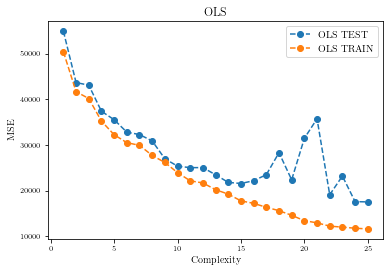

In [6]:
degrees = np.arange(1, max_degree+1)
plt.plot(degrees, mse_ols_test, "o--", label = "OLS TEST")
plt.plot(degrees, mse_ols_train, "o--", label = "OLS TRAIN")
plt.title("OLS")
plt.xlabel("Complexity")
plt.ylabel("MSE")
plt.legend()

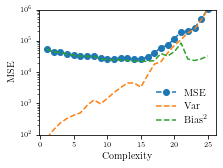

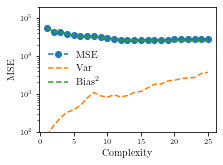

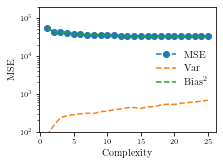

In [7]:
## BOOTSTRAP PLOTS
plt.figure(figsize=FIGURESIZE * 0.8)
plt.semilogy(degrees, ols_boot_mse,"o--",label="MSE")
plt.semilogy(degrees, ols_boot_variance,"--", label="Var")
plt.semilogy(degrees, ols_boot_bias,"--", label="Bias$^2$")
plt.xlabel("Complexity")
plt.ylabel("MSE")
plt.tight_layout()
plt.ylim([1e2, 1e6])
plt.legend(frameon=False)
plt.savefig(FIGPATH + "Terrain_bootstrap_OLS.pdf")

plt.figure(figsize=FIGURESIZE * 0.8)
plt.semilogy(degrees, ridge_best_lambda_boot_mse,"o--",label="MSE")
plt.semilogy(degrees, ridge_best_lambda_boot_variance,"--", label="Var")
plt.semilogy(degrees, ridge_best_lambda_boot_bias,"--", label="Bias$^2$")
plt.xlabel("Complexity")
plt.ylabel("MSE")
plt.ylim([1e2, 2e5])
plt.tight_layout()
plt.legend(frameon=False)
plt.savefig(FIGPATH + "Terrain_bootstrap_Ridge.pdf")

plt.figure(figsize=FIGURESIZE * 0.8)
plt.semilogy(degrees, lasso_best_lambda_boot_mse,"o--",label="MSE")
plt.semilogy(degrees, lasso_best_lambda_boot_variance,"--", label="Var")
plt.semilogy(degrees, lasso_best_lambda_boot_bias,"--", label="Bias$^2$")
plt.xlabel("Complexity")
plt.ylabel("MSE")
plt.ylim([1e2, 2e5])
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig(FIGPATH + "Terrain_bootstrap_LASSO.pdf")

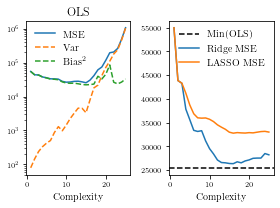

In [8]:
plt.figure(figsize= FIGURESIZE) #* np.array([1, 2]))
plt.subplot(121)
plt.semilogy(degrees, ols_boot_mse,"-",label="MSE")
plt.semilogy(degrees, ols_boot_variance,"--", label="Var")
plt.semilogy(degrees, ols_boot_bias,"--", label="Bias$^2$")
plt.title("OLS")
plt.xlabel("Complexity")
#plt.ylim([1e2, 1e6])
plt.legend(frameon=False)
plt.tight_layout()
plt.subplot(122)
#plt.figure(figsize= FIGURESIZE * np.array([0.5, 1]))
plt.axhline(min(ols_boot_mse), color="black", ls="--", alpha=1, label="Min(OLS)")
plt.plot(degrees, ridge_best_lambda_boot_mse,"-",label="Ridge MSE")
plt.plot(degrees, lasso_best_lambda_boot_mse,"-",label="LASSO MSE")
plt.xlabel("Complexity")
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig(FIGPATH+"TERRAIN_bootstrap_best_LASSO_Ridge.pdf")

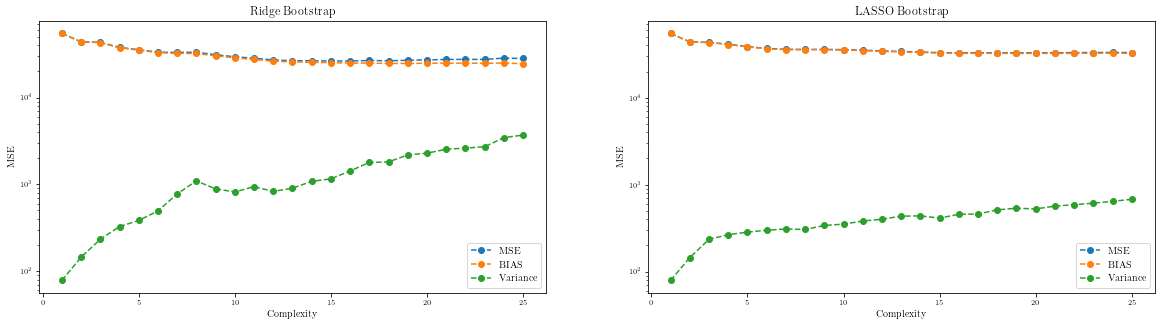

In [9]:
# Same bootstrap plots, but only better resolved LASSO & Ridge
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.semilogy(degrees, ridge_best_lambda_boot_mse,"o--",label="MSE")
plt.semilogy(degrees, ridge_best_lambda_boot_bias,"o--", label="BIAS")
plt.semilogy(degrees, ridge_best_lambda_boot_variance,"o--", label="Variance")
plt.title("Ridge Bootstrap")
plt.xlabel("Complexity")
plt.ylabel("MSE")
#plt.ylim([1e-4, 1e-1])
plt.legend()

plt.subplot(122)
plt.semilogy(degrees, lasso_best_lambda_boot_mse,"o--",label="MSE")
plt.semilogy(degrees, lasso_best_lambda_boot_bias,"o--", label="BIAS")
plt.semilogy(degrees, lasso_best_lambda_boot_variance,"o--", label="Variance")
plt.title("LASSO Bootstrap")
plt.xlabel("Complexity")
plt.ylabel("MSE")
#plt.ylim([1e-4, 1e-1])
plt.legend()
plt.show()

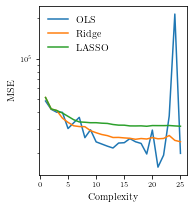

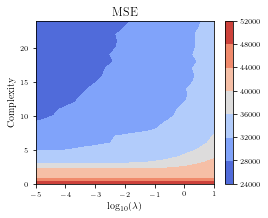

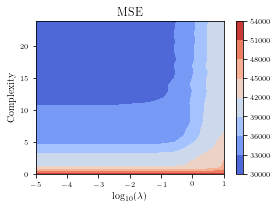

In [10]:
# CONTOUR PLOTS

plt.figure(figsize=FIGURESIZE*np.array([0.7, 1]))
#plt.axvline(degrees[np.argmin(ols_cv_mse)], ls="--", color="black", alpha=0.6)
plt.semilogy(degrees, ols_cv_mse, label="OLS")
plt.semilogy(degrees, best_ridge_mse, label="Ridge")
plt.semilogy(degrees, best_lasso_mse, label="LASSO")
plt.xlabel("Complexity")
plt.ylabel("MSE")
plt.legend(loc="best", frameon=False)
plt.tight_layout()
plt.savefig(FIGPATH + f"OLS_CV_Terrain.pdf")

# RIDGE
plt.figure(figsize=(4, 3))
X, Y = np.meshgrid(np.log10(lambdas), np.arange(max_degree))
plt.contourf(X, Y, ridge_lamb_deg_mse, cmap=cm.coolwarm)
plt.colorbar()
plt.xlabel("$\\log_{10}(\lambda)$")
plt.ylabel("Complexity")
plt.title("MSE")
plt.savefig(FIGPATH + "RIDGE_CV_Terrain_contour.pdf")

# LASSO
plt.figure(figsize=(4, 3))
X, Y = np.meshgrid(np.log10(lambdas), np.arange(max_degree))
plt.contourf(X, Y, lasso_lamb_deg_mse, cmap=cm.coolwarm)
plt.colorbar()
plt.xlabel("$\\log_{10}(\lambda)$")
plt.ylabel("Complexity")
plt.title("MSE")
plt.tight_layout()
plt.savefig(FIGPATH + "LASSO_CV_Terrain_contour.pdf")

In [11]:
print(best_ridge_lambda)
print(best_lasso_lambda)

[1.00000000e+01 1.27427499e-01 1.27427499e-01 3.35981829e-03
 1.62377674e-03 1.00000000e-05 1.00000000e-05 1.00000000e-05
 1.00000000e-05 1.00000000e-05 1.00000000e-05 1.00000000e-05
 1.00000000e-05 1.00000000e-05 1.00000000e-05 1.00000000e-05
 1.00000000e-05 1.00000000e-05 1.00000000e-05 1.00000000e-05
 1.00000000e-05 1.00000000e-05 1.00000000e-05 1.00000000e-05
 1.00000000e-05]
[1.27427499e-01 3.35981829e-03 1.00000000e-05 1.00000000e-05
 1.00000000e-05 1.00000000e-05 1.00000000e-05 1.00000000e-05
 1.00000000e-05 1.00000000e-05 1.00000000e-05 1.00000000e-05
 1.00000000e-05 1.00000000e-05 1.00000000e-05 3.35981829e-03
 1.43844989e-02 3.35981829e-03 3.35981829e-03 7.84759970e-04
 6.95192796e-03 1.00000000e-05 7.84759970e-04 1.00000000e-05
 7.84759970e-04]


In [12]:
spacing = 100 # Try 100, and try 40
degree = 13 #Try what seems best from above
ridge_lambda = 1e-4 # Ditto
lasso_lambda = 1e-2 # Ditto
np.random.seed(SEEDVAL)
# Setting up the terrain data:
# Note structure! X-coordinates are on the rows of terrain_data
# Point_selection.flatten() moves most rapidly over the x-coordinates
# Meshgrids flattened also move most rapidly over the x-coordinates. Thus
# this should make z(x,y).reshape(length_y,length_x) be consistent with terrain_data
terrain_data = imread("../datafiles/SRTM_data_Norway_1.tif")
point_selection = terrain_data[:1801:spacing, :1801:spacing]  # Make quadratic and downsample
x_terrain_selection = np.linspace(0, 1, point_selection.shape[1])
y_terrain_selection = np.linspace(0, 1, point_selection.shape[0])
X_coord_selection, Y_coord_selection = np.meshgrid(x_terrain_selection, y_terrain_selection)
z_terrain_selection = point_selection.flatten()  # the response values
x_terrain_selection_flat = X_coord_selection.flatten()  # the first degree feature variables
y_terrain_selection_flat = Y_coord_selection.flatten()  # the first degree feature variables

x = x_terrain_selection_flat
y = y_terrain_selection_flat
z = z_terrain_selection

# Centering
z_intercept = np.mean(z)
z = z - z_intercept
# Scaling
X = linear_regression.design_matrix_2D(x, y, degree)
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled = X_scaled[:,1:]

x_plot = np.linspace(0, 1, 1801)
y_plot = np.linspace(0, 1, 1801)
x_plot_mesh, y_plot_mesh = np.meshgrid(x_plot, y_plot)
x_plot_mesh_flat, y_plot_mesh_flat = x_plot_mesh.flatten(), y_plot_mesh.flatten()

X_plot_design = linear_regression.design_matrix_2D(x_plot_mesh_flat, y_plot_mesh_flat, degree)
X_plot_design_scaled = scaler.transform(X_plot_design)
X_plot_design_scaled = X_plot_design_scaled[:,1:]
# Ground truth

z_true = terrain_data[:1801, :1801]

# OLS
betas = linear_regression.OLS_SVD_2D(X_scaled, z)
z_predict_flat_ols = (X_plot_design_scaled @ betas) + z_intercept
z_predict_ols = z_predict_flat_ols.reshape(-1, 1801)

# Ridge
betas_ridge = linear_regression.Ridge_2D(X_scaled, z, ridge_lambda)
z_predict_flat_ridge = (X_plot_design_scaled @ betas_ridge) + z_intercept
z_predict_ridge = z_predict_flat_ridge.reshape(-1, 1801)
# Lasso

clf_Lasso = skl.Lasso(alpha=lasso_lambda, fit_intercept=False).fit(X_scaled, z)
z_predict_flat_lasso = clf_Lasso.predict(X_plot_design_scaled) + z_intercept
z_predict_lasso = z_predict_flat_lasso.reshape(-1, 1801)


/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4766436.66336618, tolerance: 2576.4506515235457
  model = cd_fast.enet_coordinate_descent(


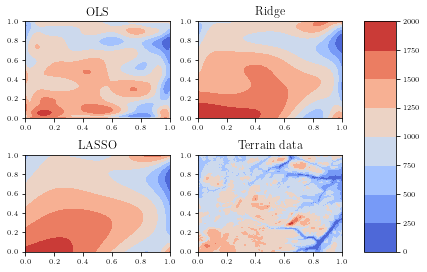

In [13]:
plt.subplot(221)
plt.contourf(x_plot_mesh, y_plot_mesh, z_predict_ols, cmap=cm.coolwarm)
plt.title("OLS")
plt.tight_layout()

plt.subplot(222)
plt.contourf(x_plot_mesh, y_plot_mesh, z_predict_ridge, cmap=cm.coolwarm)
plt.title("Ridge")
plt.tight_layout()

plt.subplot(223)
plt.contourf(x_plot_mesh, y_plot_mesh, z_predict_lasso, cmap=cm.coolwarm)
plt.title("LASSO")
plt.tight_layout()

plt.subplot(224)
plt.contourf(x_plot_mesh, y_plot_mesh, z_true, cmap=cm.coolwarm)
plt.title("Terrain data")
plt.tight_layout()


plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)

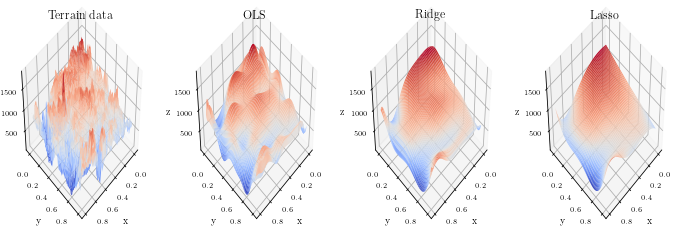

In [14]:
fig = plt.figure(figsize=(3 * 4,4))

# Plot the true terrain data
ax = fig.add_subplot(1, 4, 1, projection="3d")
ax.set_title("Terrain data")
ax.view_init(azim=45, elev=50)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_zlim([np.amin(z_true), np.amax(z_true)])
surf = ax.plot_surface(x_plot_mesh, y_plot_mesh, z_true, cmap=cm.coolwarm)

# Plot the OLS prediction
ax = fig.add_subplot(1, 4, 2, projection="3d")
ax.set_title("OLS")
ax.view_init(azim=45, elev=50)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_zlim([np.amin(z_true), np.amax(z_true)])
surf = ax.plot_surface(x_plot_mesh, y_plot_mesh, z_predict_ols, cmap=cm.coolwarm)

ax = fig.add_subplot(1, 4, 3, projection="3d")
ax.set_title("Ridge")
ax.view_init(azim=45, elev=50)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_zlim([np.amin(z_true), np.amax(z_true)])
surf = ax.plot_surface(x_plot_mesh, y_plot_mesh, z_predict_ridge, cmap=cm.coolwarm)

ax = fig.add_subplot(1, 4, 4, projection="3d")
ax.set_title("Lasso")
ax.view_init(azim=45, elev=50)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_zlim([np.amin(z_true), np.amax(z_true)])
surf = ax.plot_surface(x_plot_mesh, y_plot_mesh, z_predict_lasso, cmap=cm.coolwarm)

plt.show()

